# Detecting Brain Tumors by extracting features using neural networks and then using Classical ML Models for prediction

<h3>author : Abhranta Panigrahi</h3>
<h3>date :  6th March, 2021</h3>

<h2> DataSet Description </h2>

<p> The image data that was used for this problem is <a href = "https://www.kaggle.com/abhranta/brain-tumor-detection-mri">Brain MRI scans for tumor detection</a>. It consists of MRI scans of the human brain. It has three sub-directories:
        <ul>
            <li><b>no</b> :  These are the MRI scans of the brain that have no tumors. These are labelled as 0.</li>
            <li><b>yes</b> : These are the MRI scans of the brain that have a tumor, These are labelles as 1. </li>
            <li><b>pred</b> : These images are the unlabelled images. These are meant to be used as the test set. </li>
    

<h2> Brain Tumor</h2>
<p>>A brain tumor is a collection, or mass, of abnormal cells in your brain. Your skull, which encloses your brain, is very rigid. Any growth inside such a restricted space can cause problems. Brain tumors can be cancerous (malignant) or noncancerous (benign). When benign or malignant tumors grow, they can cause the pressure inside your skull to increase. This can cause brain damage, and it can be life-threatening.</p>
<img src = "https://img.medscapestatic.com/pi/features/slideshow-slide/pediatric-brain-tumors-6009019/fig1.jpg?resize=580:*">

<h2> MRI </h2>
<p>Magnetic resonance imaging (MRI) is a medical imaging technique used in radiology to form pictures of the anatomy and the physiological processes of the body. MRI scanners use strong magnetic fields, magnetic field gradients, and radio waves to generate images of the organs in the body. MRI does not involve X-rays or the use of ionizing radiation, which distinguishes it from CT and PET scans. MRI is a medical application of nuclear magnetic resonance (NMR) which can also be used for imaging in other NMR applications, such as NMR spectroscopy.</p>
<img src = "https://i.pinimg.com/originals/49/6d/95/496d952e43d6a3b9aa87ef63a73e11fe.gif">

<h2> In this notebook we will be extracting the features using Neural Networks and using standard ML Classifiers to classify the data based on the extracted features. </h2>

<h3>Neural networks used </h3>
<ol>
    <li><b>VGG-16</b></li>
    <li><b>VGG-19</b></li>
    <li><b>ResNet50</b></li>
    <li><b>ResNet101</b></li>
    <li><b>MobileNetv2</b></li>
    <li><b>MobileNet</b></li>
    <li><b>Inceptionv3</b></li>
    <li><b>InceptionResnetv2</b></li>
    <li><b>DenseNet169</b></li>
    <li><b>DenseNet121</b></li>
    <li><b>XceptionNet</b></li>
</ol>
<h3>Classifiers used</h3>
<ol>
    <li><b>ANN</b></li>
    <li><b>SVM => SVC</b></li>
    <li><b>Random Forest Classifier</b></li>
    <li><b>AdaBoost Classifier</b></li>
    <li><b>XGBoost Classifier</b></li>
    <li><b> KNN Classifier</b></li>
   

<h3>1. Import all the necessary Libraries</h3>

In [1]:
from IPython.display import clear_output
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=e503baec30e0237035714590abb85e9f425f342f751fb59e117f5e35b88cd9e2
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [2]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy
import  os
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
import shutil
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
# import pydot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier

print("All modules have been imported")

All modules have been imported


Right now all images are in one folder with `yes` and `no` subfolders. I will split the data into `train`, `val` and `test` folders which makes its easier to work for me. The new folder heirarchy will look as follows:

In [3]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

9 directories


In [4]:
IMG_PATH = "../input/brain-tumor-detection-mri/Brain_Tumor_Detection"

# split the data by train/val/test
ignored = {"pred"}
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if CLASS not in ignored:
        if not CLASS.startswith('.'):
            IMG_NUM = len(os.listdir(IMG_PATH +"/"+ CLASS))
            for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH +"/"+ CLASS)):
                img = IMG_PATH+ '/' +  CLASS + '/' + FILE_NAME
                if n < 300:
                    shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
                elif n < 0.8*IMG_NUM:
                    shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
                else:
                    shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

<h3>Data Importing and Preprocessing</h3>

In [5]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [6]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:03<00:00,  1.67s/it]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

  0%|          | 0/2 [00:00<?, ?it/s]

1800 images loaded from TRAIN/ directory.


  0%|          | 0/2 [00:00<?, ?it/s]

600 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

600 images loaded from VAL/ directory.


In [7]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [8]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

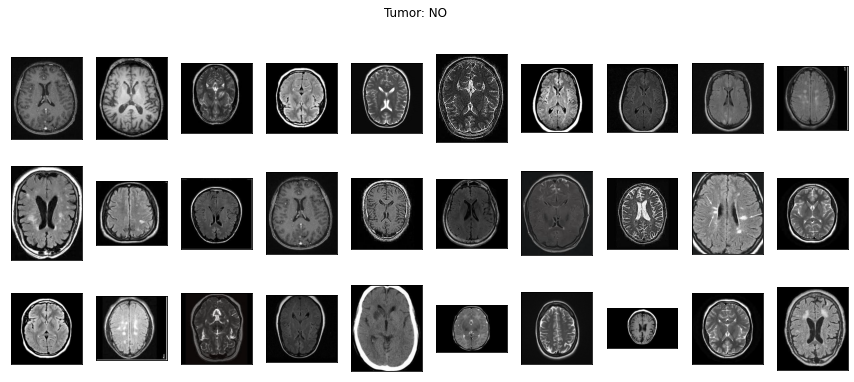

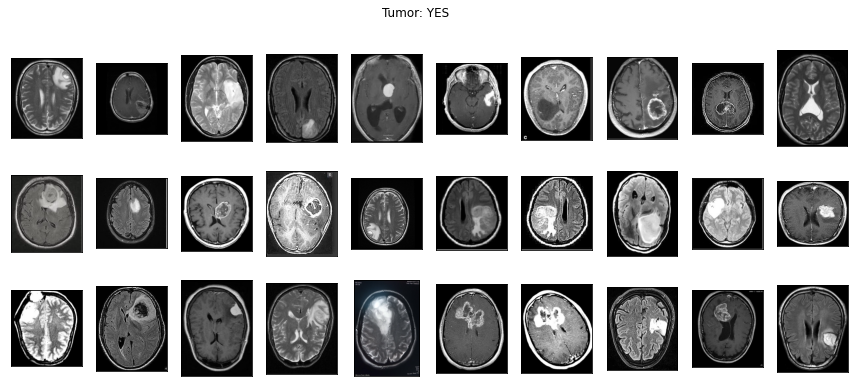

In [9]:
plot_samples(X_train, y_train, labels, 30)

As you can see, images have different width and height and diffent size of "black corners". Since the image size for VGG-16 imput layer is (224,224) some wide images may look weird after resizing. Histogram of ratio distributions (ratio = width/height):

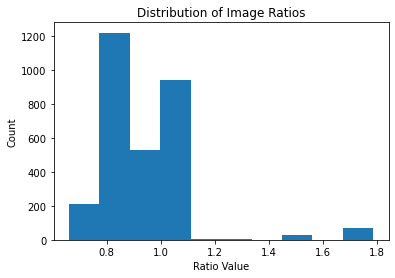

In [10]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

<p> First I will be cropping the  images out so that they noly contain the brain and no excess data.</p>
<p> This was done by finding extreme points in image contours<p>

In [11]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [12]:
import imutils
img = cv2.imread('./VAL/NO/no852.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

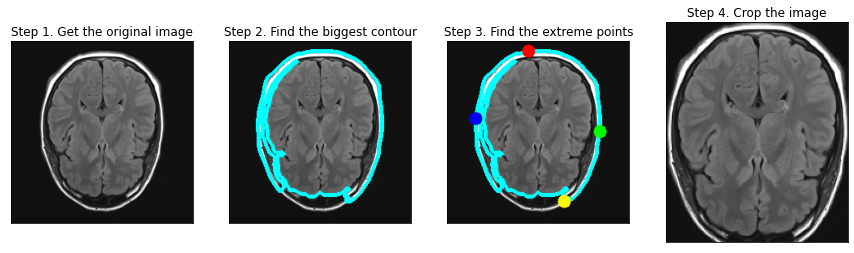

In [13]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [14]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



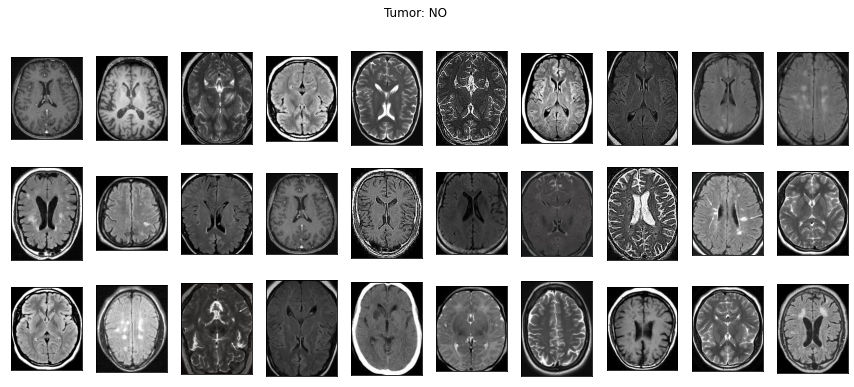

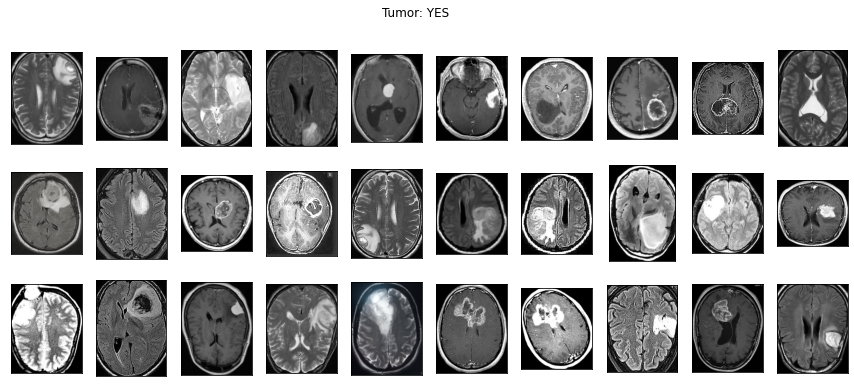

In [15]:
plot_samples(X_train_crop, y_train, labels, 30)

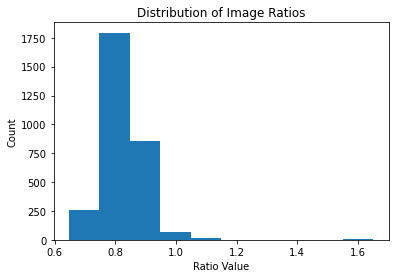

In [16]:
RATIO_LIST = []
for set in (X_train_crop, X_test_crop, X_val_crop):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [17]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [18]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

<h2>Resizing the Images</h2>

<p> Since all the neural entwork models take input of size (224x224x3) hence all the images were interpolated using Inter Cubic interpolation and open cv </p>

In [19]:
def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [20]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

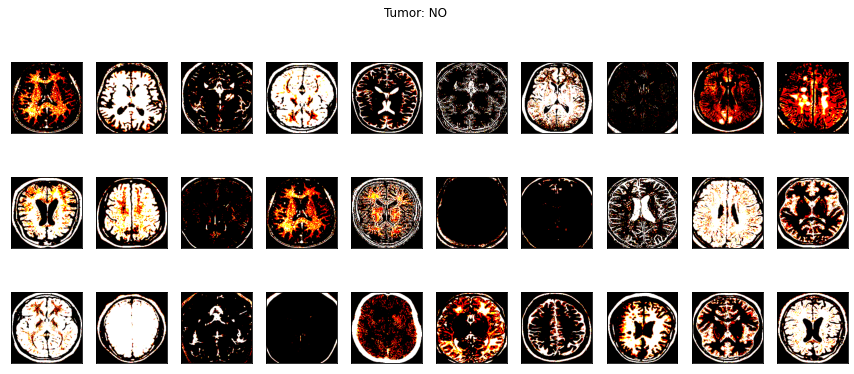

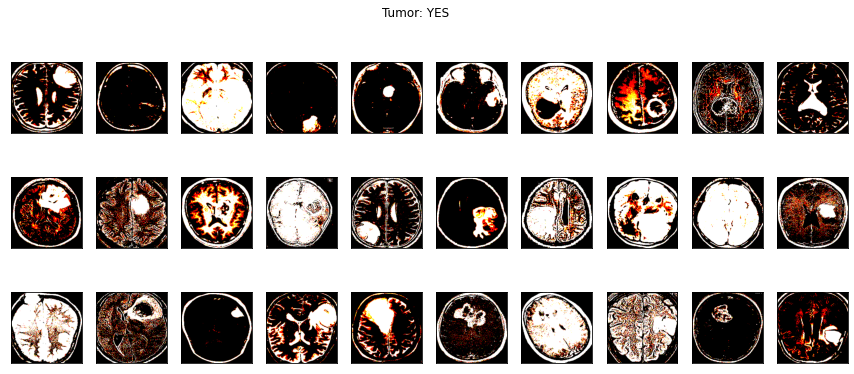

In [21]:
plot_samples(X_train_prep, y_train, labels, 30)

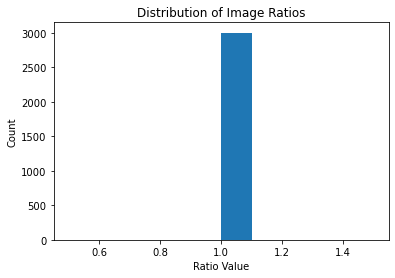

In [22]:
RATIO_LIST = []
for set in (X_train_prep, X_test_prep, X_val_prep):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

<h2>Image Augmentation</h2>
<p> As the number of training samples is not that great, hence all the images went through a few augmentations to iirease the number of samples. </p>

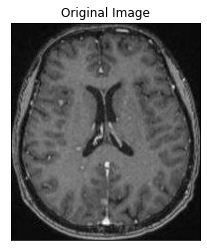

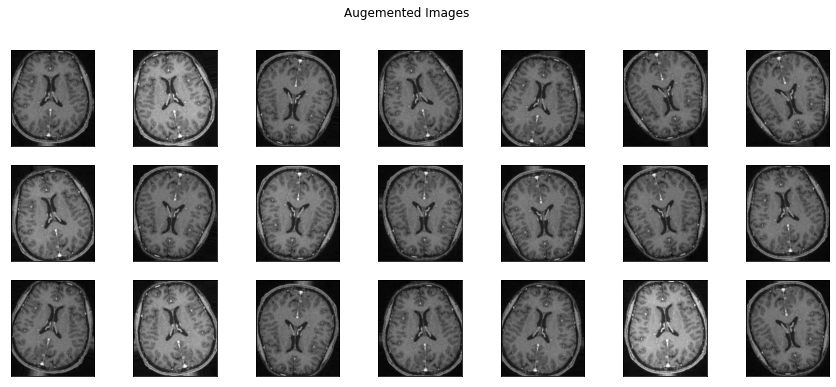

In [23]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 
        
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [24]:
!rm -rf preview/

In [25]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'
RANDOM_SEED = 42
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


<h2> Now we willl be creating our ML Classifiers </h2>

<h2> Building the Classification Pipeline </h2>

In [96]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
names = [
        "K Nearest Neighbour Classifier",
        'SVM',
        "Random Forest Classifier",
        "AdaBoost Classifier", 
        "XGB Classifier",
        "ANN Classifier"
         ]
classifiers = [
    KNeighborsClassifier(),
    SVC(probability = True),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    XGBClassifier(),
    MLPClassifier()
        ]
zipped_clf = zip(names,classifiers)
def classifier_summary(pipeline, X_train, y_train, X_val, y_val,X_test,y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)
    
    y_pred_train= sentiment_fit.predict(X_train)
    y_pred_val = sentiment_fit.predict(X_val)
    y_pred_test = sentiment_fit.predict(X_test)
    y_pred_train = [1 if x>0.5 else 0 for x in y_pred_train]
    y_pred_val = [1 if x>0.5 else 0 for x in y_pred_val]
    y_pred_test = [1 if x>0.5 else 0 for x in y_pred_test]

    train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
    train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
    train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
    train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)
    train_kappa =  np.round(cohen_kappa_score(y_train, y_pred_train),4)
    
    
    val_accuracy = np.round(accuracy_score(y_val, y_pred_val),4)*100
    val_precision = np.round(precision_score(y_val, y_pred_val, average='weighted'),4)
    val_recall = np.round(recall_score(y_val, y_pred_val, average='weighted'),4)
    val_F1 = np.round(f1_score(y_val, y_pred_val, average='weighted'),4)
    val_kappa =  np.round(cohen_kappa_score(y_val, y_pred_val),4)
   
    
    test_accuracy = np.round(accuracy_score(y_test, y_pred_test),4)*100
    test_precision = np.round(precision_score(y_test, y_pred_test, average='weighted'),2)
    test_recall = np.round(recall_score(y_test, y_pred_test, average='weighted'),2)
    test_F1 = np.round(f1_score(y_test, y_pred_test, average='weighted'),2)
    test_kappa =  np.round(cohen_kappa_score(y_test, y_pred_test),2)
    test_roc_auc = metrics.roc_auc_score(y_test, y_pred_test ,multi_class='ovo', average='weighted')
    
    print()
    print('------------------------ Train Set Metrics------------------------')
    print()
    print("Accuracy core : {}%".format(train_accuracy))
    confusion_mtx = confusion_matrix(y_train, y_pred_train) 
    cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)
    
    print('------------------------ Validation Set Metrics------------------------')
    print()
    print("Accuracy score : {}%".format(val_accuracy))
    confusion_mtx = confusion_matrix(y_val, y_pred_val) 
    cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)
    
    print('------------------------ Test Set Metrics------------------------')
    print()
    print("Accuracy score : {}%".format(test_accuracy))
    print("F1_score : {}".format(test_F1))
    print("Kappa Score : {} ".format(test_kappa))
    print("Recall score: {}".format(test_recall))
    print("Precision score : {}".format(test_precision))
    print("ROC AUC score : {}".format(test_roc_auc))
    confusion_mtx = confusion_matrix(y_test, y_pred_test) 
    cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)
    
    print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred_test))
    
    print("-"*80)
    print()

In [97]:
def classifier_comparator(X_train,y_train,X_val,y_val,X_test,y_test,classifier=zipped_clf): 
    result = []
    for n,c in classifier:
        checker_pipeline = Pipeline([('Classifier', c)])
        print("------------------------------Fitting {} on input_data-------------------------------- ".format(n))
        #print(c)
        classifier_summary(checker_pipeline,X_train, y_train, X_val, y_val,X_test,y_test)

<h2> Training </h2>
<p> From here on, we will be using various neural networks woith pretrained Image Net weights and extracting a latent representation of our data. This representation will then be used by classical ML models such as K Nearest Neighbours, Support Vector MAchines, etc. to perform the classification task. Various metrics will then be used to evaluate the performance of the models. 

# ResNet-50

In [56]:
base_model= ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = base_model.output
x = Dropout(0.5)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
predictions = Activation('relu')(x)
#x = Dropout(0.5)(x)

#predictions = Dense(1, activation='sigmoid')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(X_train_prep)
val_features=model_feat.predict(X_val_prep)
test_features=model_feat.predict(X_test_prep)

------------------------------Fitting K Nearest Neighbour Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 92.11%


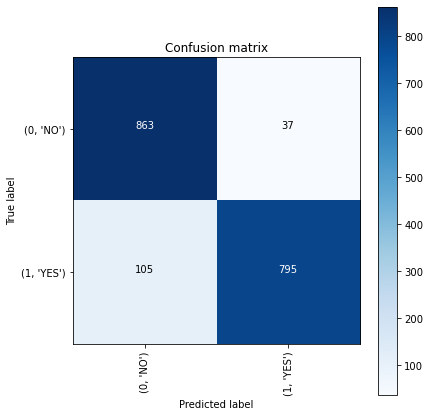

------------------------ Validation Set Metrics------------------------

Accuracy score : 85.17%


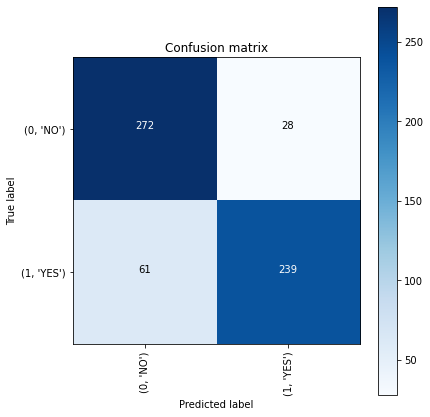

------------------------ Test Set Metrics------------------------

Accuracy score : 85.33%
F1_score : 0.85
Kappa Score : 0.71 
Recall score: 0.85
Precision score : 0.86
ROC AUC score : 0.8533333333333334


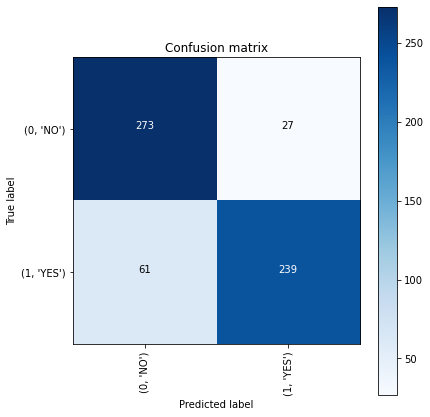

		Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86       300
           1       0.90      0.80      0.84       300

    accuracy                           0.85       600
   macro avg       0.86      0.85      0.85       600
weighted avg       0.86      0.85      0.85       600

--------------------------------------------------------------------------------

------------------------------Fitting SVM on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 92.78%


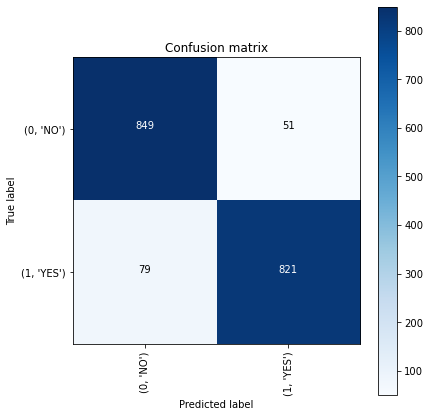

------------------------ Validation Set Metrics------------------------

Accuracy score : 87.83%


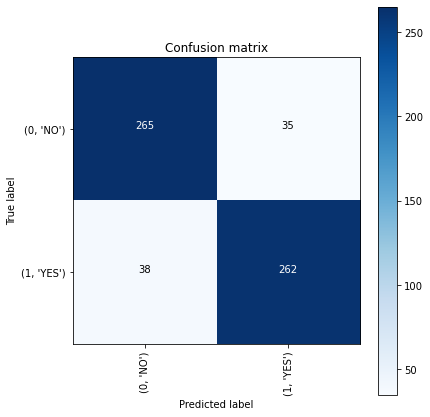

------------------------ Test Set Metrics------------------------

Accuracy score : 85.0%
F1_score : 0.85
Kappa Score : 0.7 
Recall score: 0.85
Precision score : 0.85
ROC AUC score : 0.85


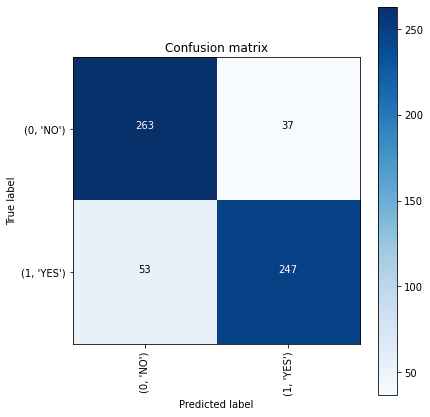

		Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       300
           1       0.87      0.82      0.85       300

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600

--------------------------------------------------------------------------------

------------------------------Fitting Random Forest Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


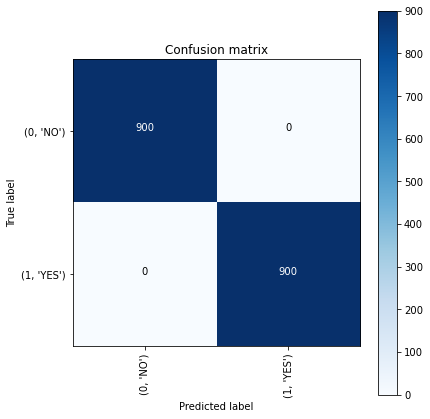

------------------------ Validation Set Metrics------------------------

Accuracy score : 86.67%


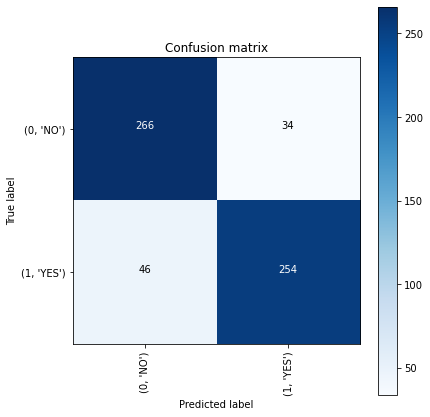

------------------------ Test Set Metrics------------------------

Accuracy score : 84.5%
F1_score : 0.84
Kappa Score : 0.69 
Recall score: 0.84
Precision score : 0.85
ROC AUC score : 0.845


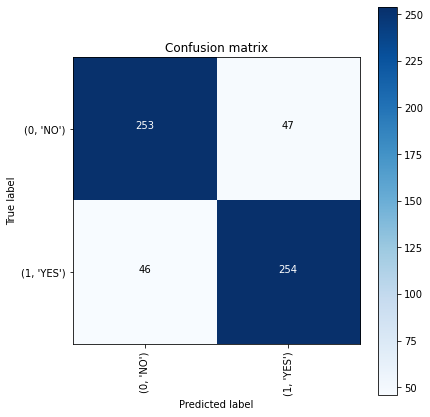

		Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.84       300
           1       0.84      0.85      0.85       300

    accuracy                           0.84       600
   macro avg       0.85      0.84      0.84       600
weighted avg       0.85      0.84      0.84       600

--------------------------------------------------------------------------------

------------------------------Fitting AdaBoost Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 85.5%


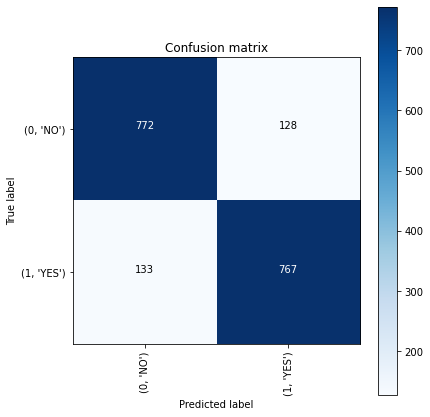

------------------------ Validation Set Metrics------------------------

Accuracy score : 81.33%


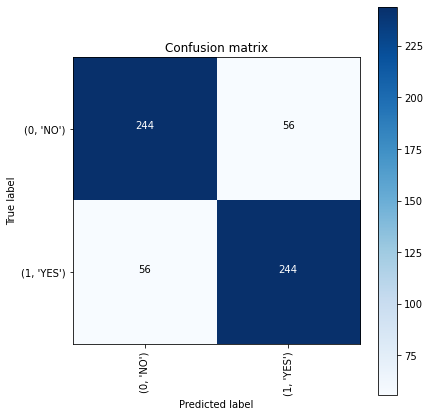

------------------------ Test Set Metrics------------------------

Accuracy score : 78.83%
F1_score : 0.79
Kappa Score : 0.58 
Recall score: 0.79
Precision score : 0.79
ROC AUC score : 0.7883333333333334


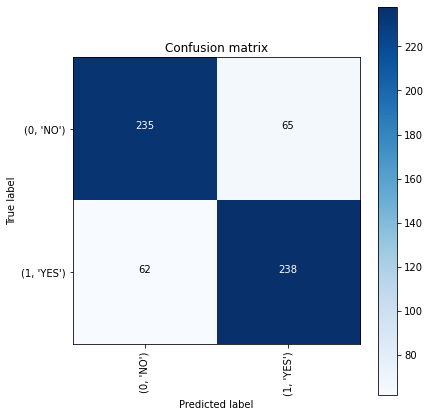

		Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.79       300
           1       0.79      0.79      0.79       300

    accuracy                           0.79       600
   macro avg       0.79      0.79      0.79       600
weighted avg       0.79      0.79      0.79       600

--------------------------------------------------------------------------------

------------------------------Fitting XGB Classifier on input_data-------------------------------- 
[16:47:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].




------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


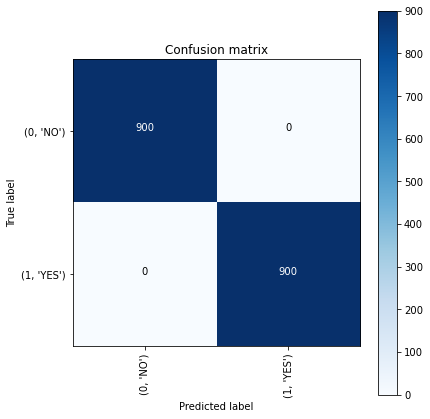

------------------------ Validation Set Metrics------------------------

Accuracy score : 87.33%


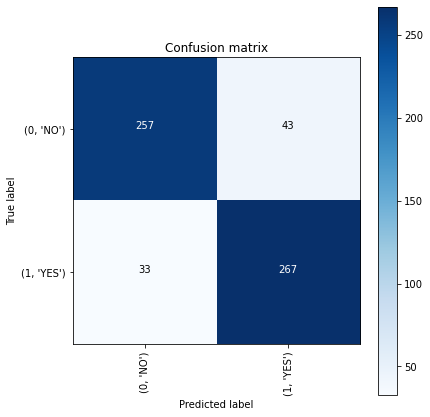

------------------------ Test Set Metrics------------------------

Accuracy score : 85.5%
F1_score : 0.85
Kappa Score : 0.71 
Recall score: 0.86
Precision score : 0.86
ROC AUC score : 0.855


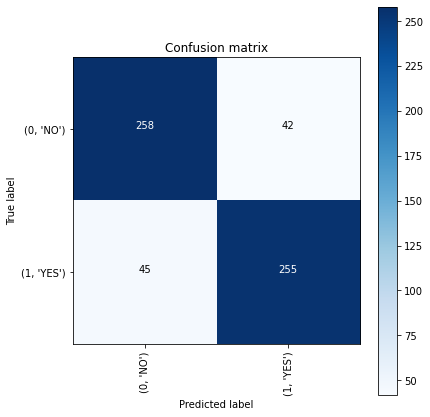

		Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.86       300
           1       0.86      0.85      0.85       300

    accuracy                           0.85       600
   macro avg       0.86      0.85      0.85       600
weighted avg       0.86      0.85      0.85       600

--------------------------------------------------------------------------------

------------------------------Fitting ANN Classifier on input_data-------------------------------- 


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.




------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


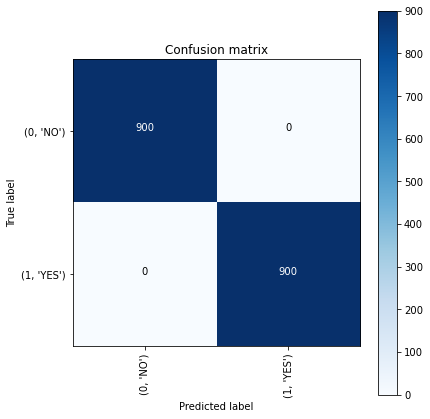

------------------------ Validation Set Metrics------------------------

Accuracy score : 88.33%


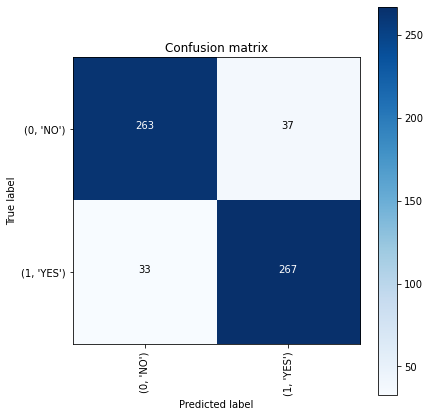

------------------------ Test Set Metrics------------------------

Accuracy score : 89.0%
F1_score : 0.89
Kappa Score : 0.78 
Recall score: 0.89
Precision score : 0.89
ROC AUC score : 0.89


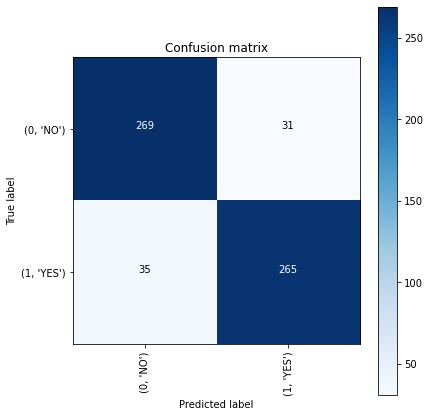

		Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89       300
           1       0.90      0.88      0.89       300

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600

--------------------------------------------------------------------------------



In [57]:
classifier_comparator(train_features,y_train,val_features,y_val,test_features,y_test,classifier=zipped_clf)

# VGG-16

In [62]:
base_model= VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = base_model.output
x = Dropout(0.5)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
predictions = Activation('relu')(x)
#x = Dropout(0.5)(x)
#predictions = Dense(1 , activation='sigmoid')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(X_train_prep)
val_features=model_feat.predict(X_val_prep)
test_features=model_feat.predict(X_test_prep)

------------------------------Fitting K Nearest Neighbour Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 86.94%


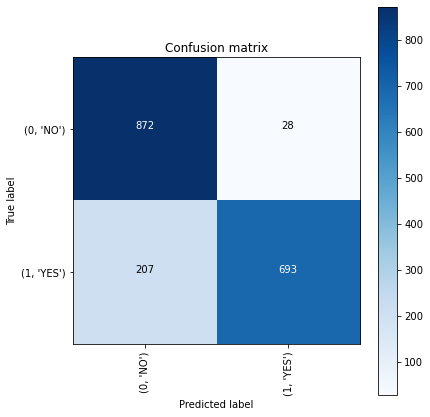

------------------------ Validation Set Metrics------------------------

Accuracy score : 78.83%


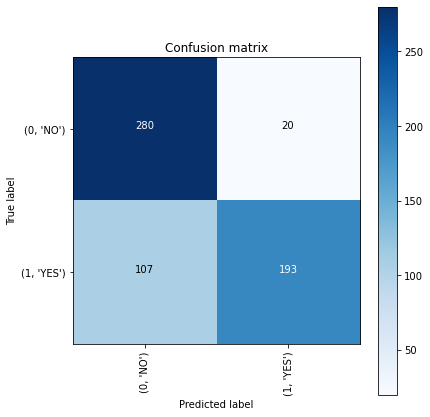

------------------------ Test Set Metrics------------------------

Accuracy score : 80.5%
F1_score : 0.8
Kappa Score : 0.61 
Recall score: 0.8
Precision score : 0.83
ROC AUC score : 0.805


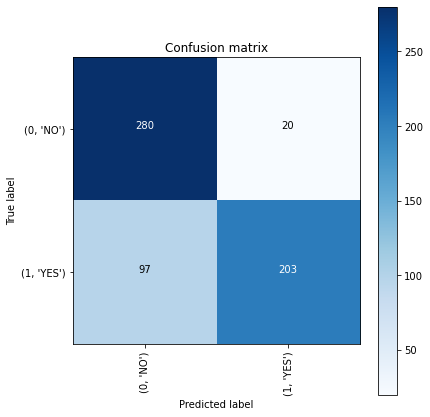

		Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.93      0.83       300
           1       0.91      0.68      0.78       300

    accuracy                           0.81       600
   macro avg       0.83      0.80      0.80       600
weighted avg       0.83      0.81      0.80       600

--------------------------------------------------------------------------------

------------------------------Fitting SVM on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 90.06%


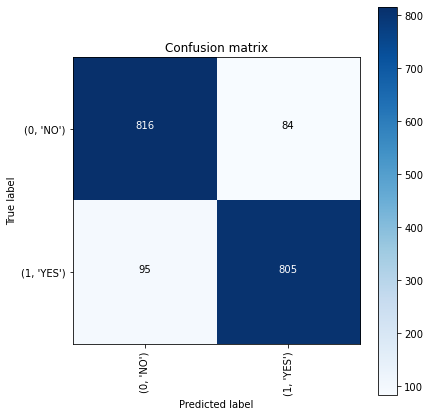

------------------------ Validation Set Metrics------------------------

Accuracy score : 81.0%


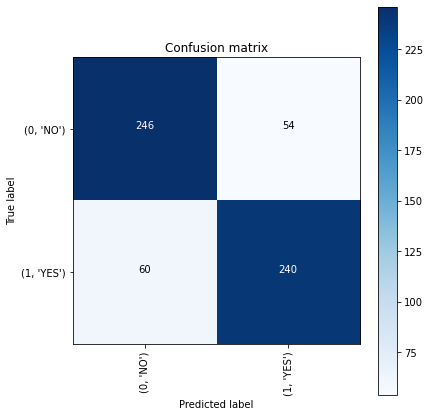

------------------------ Test Set Metrics------------------------

Accuracy score : 82.83%
F1_score : 0.83
Kappa Score : 0.66 
Recall score: 0.83
Precision score : 0.83
ROC AUC score : 0.8283333333333334


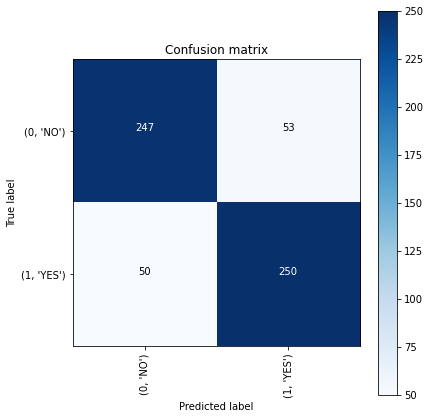

		Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.83       300
           1       0.83      0.83      0.83       300

    accuracy                           0.83       600
   macro avg       0.83      0.83      0.83       600
weighted avg       0.83      0.83      0.83       600

--------------------------------------------------------------------------------

------------------------------Fitting Random Forest Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


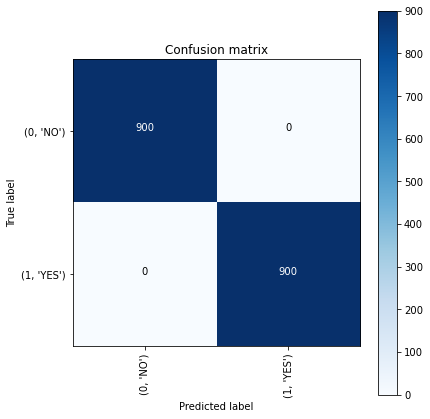

------------------------ Validation Set Metrics------------------------

Accuracy score : 81.67%


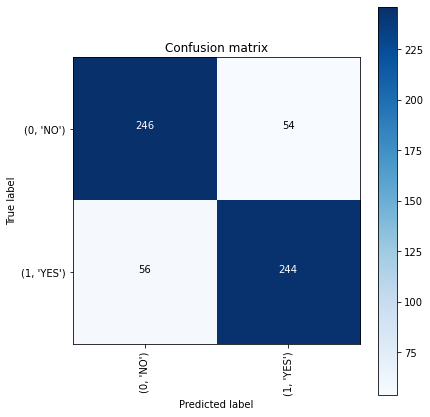

------------------------ Test Set Metrics------------------------

Accuracy score : 82.33%
F1_score : 0.82
Kappa Score : 0.65 
Recall score: 0.82
Precision score : 0.82
ROC AUC score : 0.8233333333333334


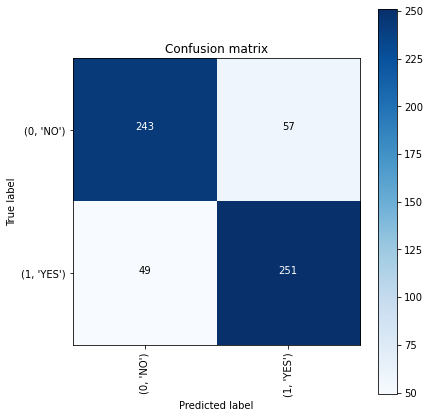

		Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82       300
           1       0.81      0.84      0.83       300

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600

--------------------------------------------------------------------------------

------------------------------Fitting AdaBoost Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 81.11%


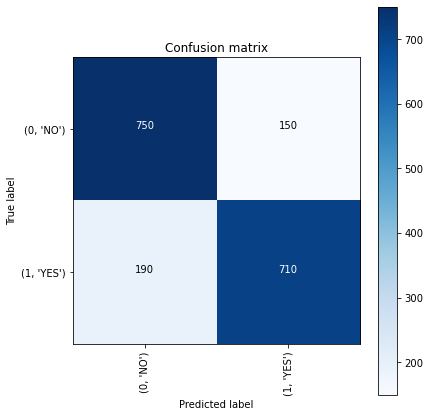

------------------------ Validation Set Metrics------------------------

Accuracy score : 75.17%


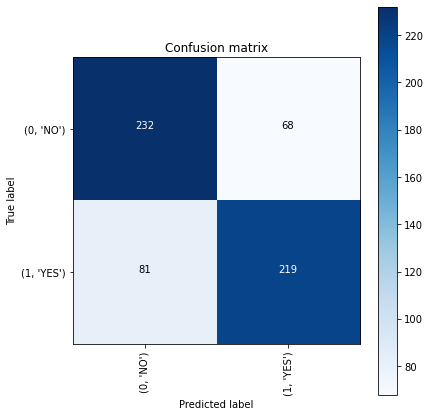

------------------------ Test Set Metrics------------------------

Accuracy score : 73.5%
F1_score : 0.73
Kappa Score : 0.47 
Recall score: 0.74
Precision score : 0.74
ROC AUC score : 0.735


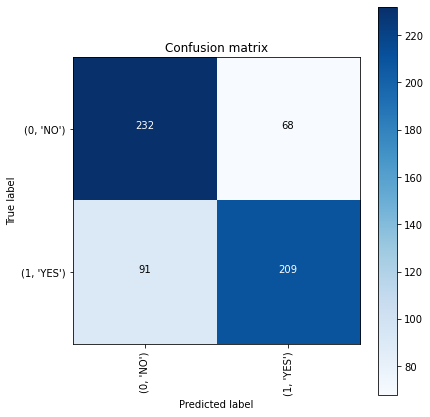

		Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.77      0.74       300
           1       0.75      0.70      0.72       300

    accuracy                           0.73       600
   macro avg       0.74      0.73      0.73       600
weighted avg       0.74      0.73      0.73       600

--------------------------------------------------------------------------------

------------------------------Fitting XGB Classifier on input_data-------------------------------- 
[16:52:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].




------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


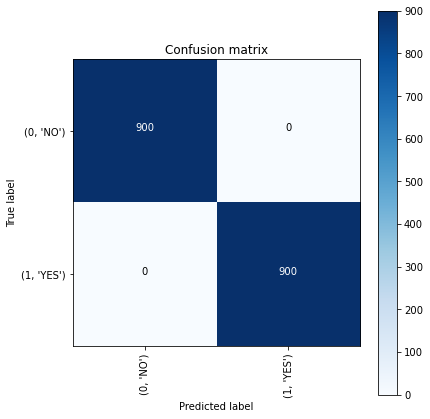

------------------------ Validation Set Metrics------------------------

Accuracy score : 82.17%


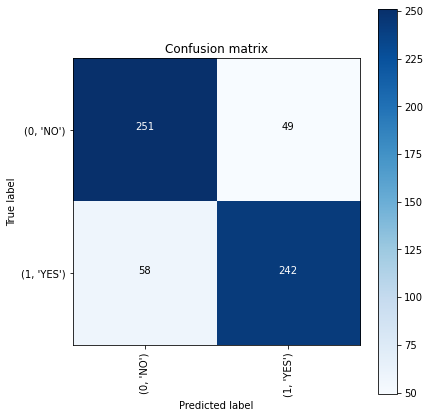

------------------------ Test Set Metrics------------------------

Accuracy score : 83.67%
F1_score : 0.84
Kappa Score : 0.67 
Recall score: 0.84
Precision score : 0.84
ROC AUC score : 0.8366666666666667


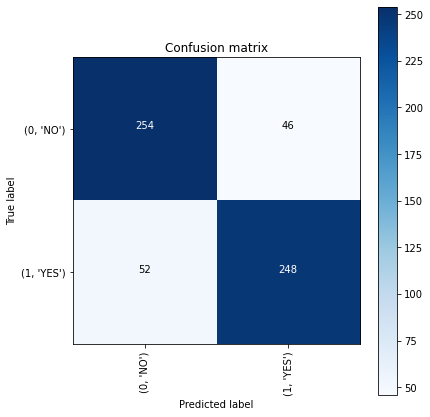

		Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84       300
           1       0.84      0.83      0.84       300

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600

--------------------------------------------------------------------------------

------------------------------Fitting ANN Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


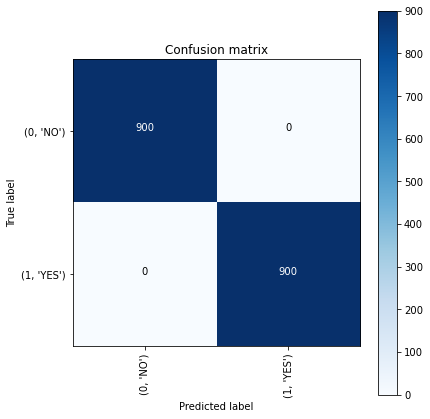

------------------------ Validation Set Metrics------------------------

Accuracy score : 84.33%


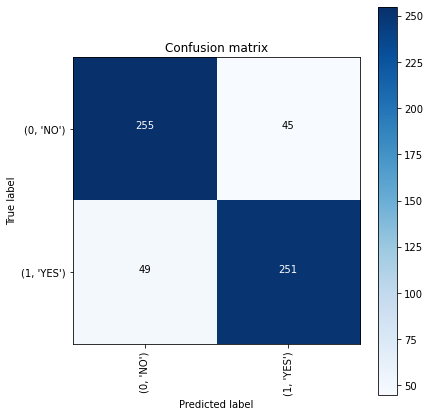

------------------------ Test Set Metrics------------------------

Accuracy score : 84.67%
F1_score : 0.85
Kappa Score : 0.69 
Recall score: 0.85
Precision score : 0.85
ROC AUC score : 0.8466666666666667


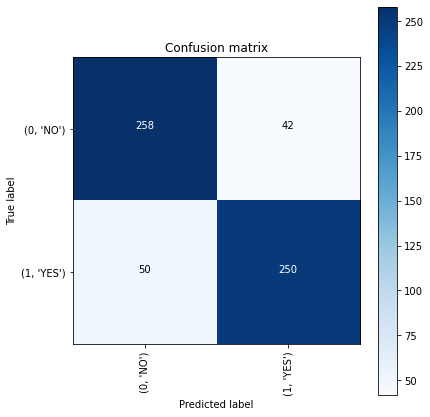

		Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85       300
           1       0.86      0.83      0.84       300

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600

--------------------------------------------------------------------------------



In [63]:
classifier_comparator(train_features,y_train,val_features,y_val,test_features,y_test,classifier=zipped_clf)

# VGG-19

In [66]:
base_model= VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = base_model.output
x = Dropout(0.5)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
predictions = Activation('relu')(x)
#x = Dropout(0.5)(x)
#predictions = Dense(3, activation='softmax')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(X_train_prep)
val_features=model_feat.predict(X_val_prep)
test_features=model_feat.predict(X_test_prep)

80142336/80134624 [==============================] - 1s 0us/step


------------------------------Fitting K Nearest Neighbour Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 87.33%


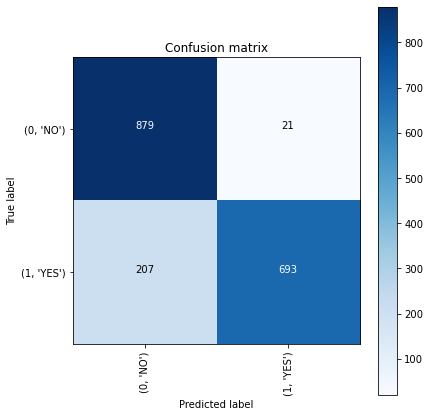

------------------------ Validation Set Metrics------------------------

Accuracy score : 78.33%


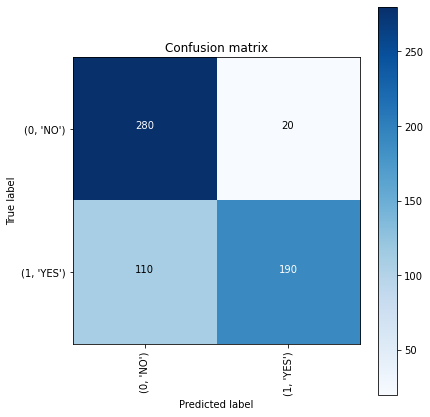

------------------------ Test Set Metrics------------------------

Accuracy score : 79.17%
F1_score : 0.79
Kappa Score : 0.58 
Recall score: 0.79
Precision score : 0.81
ROC AUC score : 0.7916666666666667


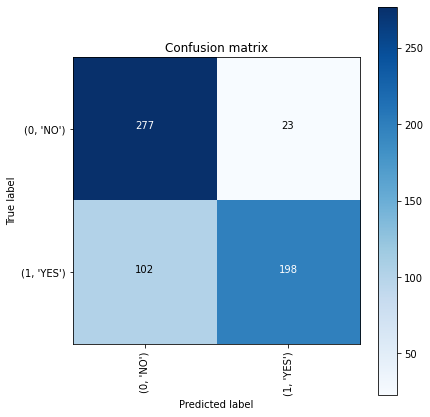

		Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.92      0.82       300
           1       0.90      0.66      0.76       300

    accuracy                           0.79       600
   macro avg       0.81      0.79      0.79       600
weighted avg       0.81      0.79      0.79       600

--------------------------------------------------------------------------------

------------------------------Fitting SVM on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 91.72%


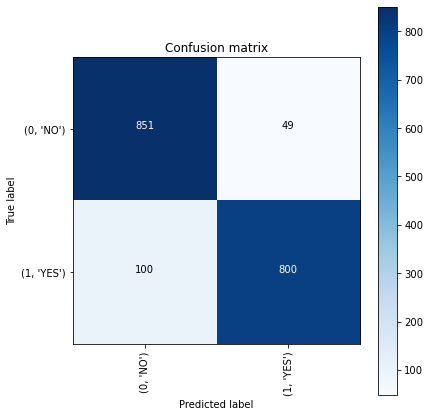

------------------------ Validation Set Metrics------------------------

Accuracy score : 86.5%


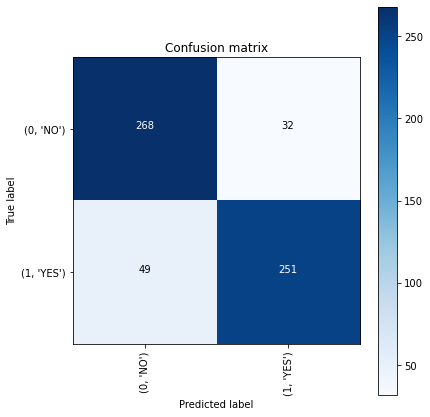

------------------------ Test Set Metrics------------------------

Accuracy score : 84.33%
F1_score : 0.84
Kappa Score : 0.69 
Recall score: 0.84
Precision score : 0.84
ROC AUC score : 0.8433333333333334


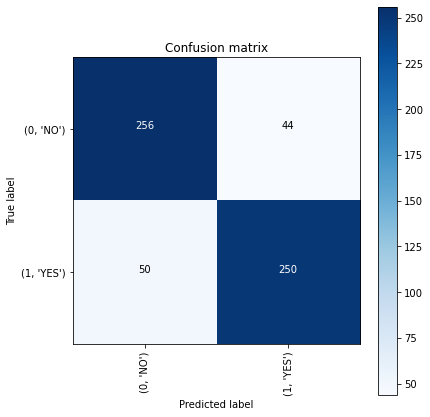

		Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.84       300
           1       0.85      0.83      0.84       300

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600

--------------------------------------------------------------------------------

------------------------------Fitting Random Forest Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


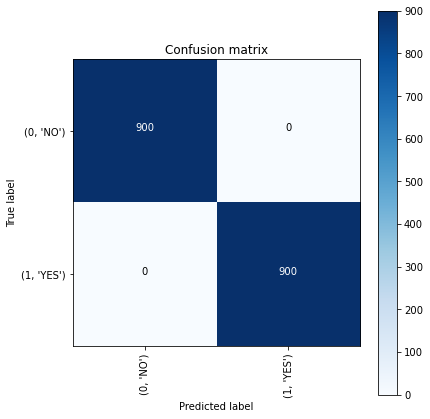

------------------------ Validation Set Metrics------------------------

Accuracy score : 85.0%


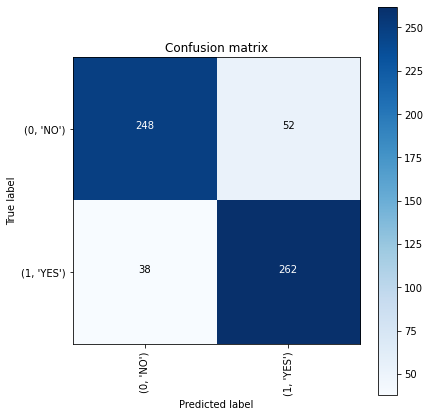

------------------------ Test Set Metrics------------------------

Accuracy score : 85.33%
F1_score : 0.85
Kappa Score : 0.71 
Recall score: 0.85
Precision score : 0.85
ROC AUC score : 0.8533333333333333


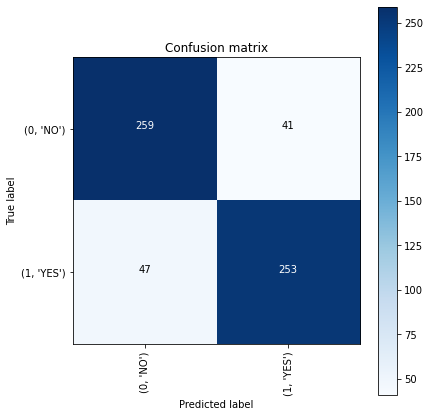

		Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.85       300
           1       0.86      0.84      0.85       300

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600

--------------------------------------------------------------------------------

------------------------------Fitting AdaBoost Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 84.06%


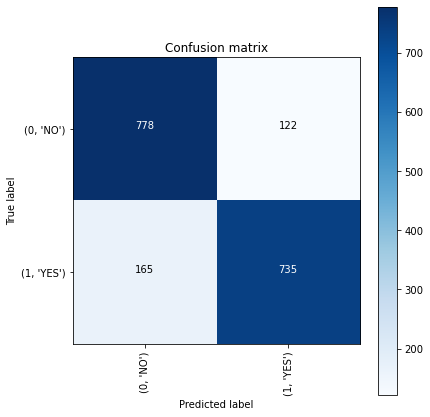

------------------------ Validation Set Metrics------------------------

Accuracy score : 76.0%


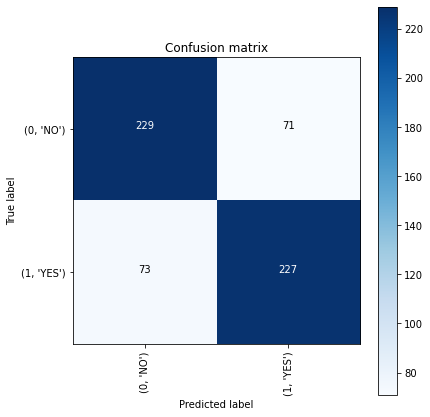

------------------------ Test Set Metrics------------------------

Accuracy score : 77.33%
F1_score : 0.77
Kappa Score : 0.55 
Recall score: 0.77
Precision score : 0.77
ROC AUC score : 0.7733333333333334


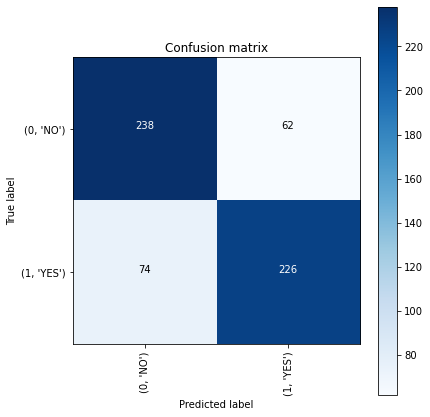

		Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.79      0.78       300
           1       0.78      0.75      0.77       300

    accuracy                           0.77       600
   macro avg       0.77      0.77      0.77       600
weighted avg       0.77      0.77      0.77       600

--------------------------------------------------------------------------------

------------------------------Fitting XGB Classifier on input_data-------------------------------- 
[16:54:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].




------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


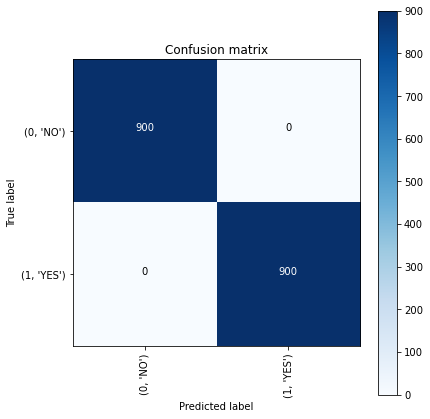

------------------------ Validation Set Metrics------------------------

Accuracy score : 85.67%


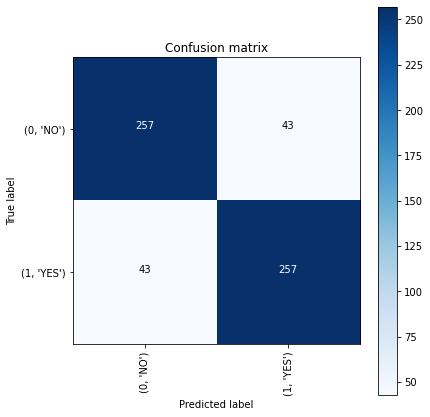

------------------------ Test Set Metrics------------------------

Accuracy score : 86.0%
F1_score : 0.86
Kappa Score : 0.72 
Recall score: 0.86
Precision score : 0.86
ROC AUC score : 0.86


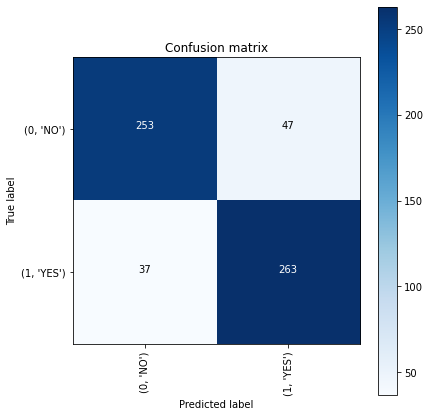

		Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.84      0.86       300
           1       0.85      0.88      0.86       300

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600

--------------------------------------------------------------------------------

------------------------------Fitting ANN Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


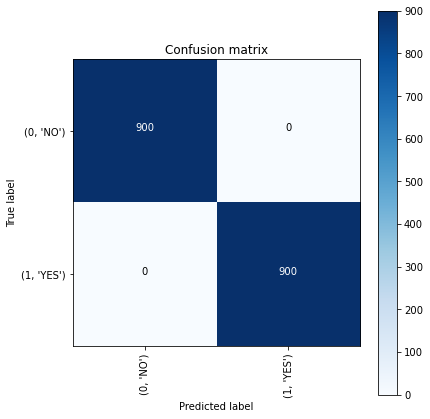

------------------------ Validation Set Metrics------------------------

Accuracy score : 87.17%


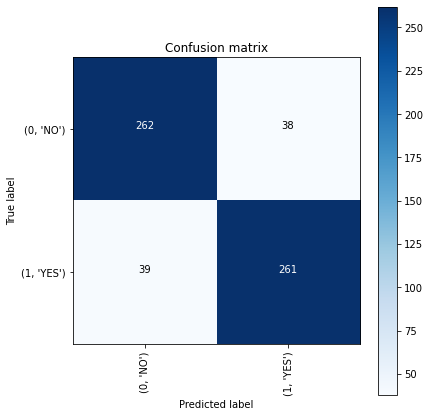

------------------------ Test Set Metrics------------------------

Accuracy score : 85.33%
F1_score : 0.85
Kappa Score : 0.71 
Recall score: 0.85
Precision score : 0.85
ROC AUC score : 0.8533333333333333


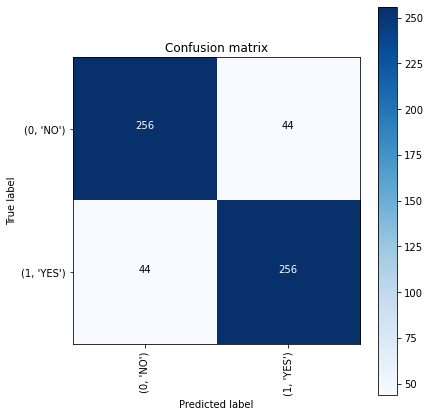

		Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       300
           1       0.85      0.85      0.85       300

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600

--------------------------------------------------------------------------------



In [67]:
classifier_comparator(train_features,y_train,val_features,y_val,test_features,y_test,classifier=zipped_clf)

# ResNet101

In [70]:
base_model= ResNet101(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
predictions = Activation('relu')(x)
#x = Dropout(0.5)(x)
#predictions = Dense(3, activation='softmax')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(X_train_prep)
val_features=model_feat.predict(X_val_prep)
test_features=model_feat.predict(X_test_prep)

171450368/171446536 [==============================] - 2s 0us/step


------------------------------Fitting K Nearest Neighbour Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 92.89%


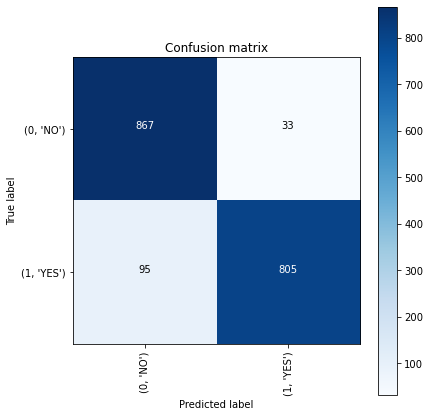

------------------------ Validation Set Metrics------------------------

Accuracy score : 87.5%


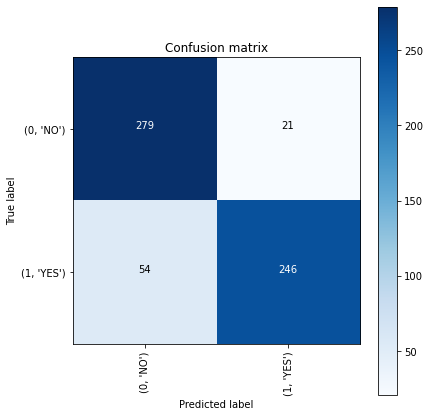

------------------------ Test Set Metrics------------------------

Accuracy score : 88.5%
F1_score : 0.88
Kappa Score : 0.77 
Recall score: 0.88
Precision score : 0.89
ROC AUC score : 0.8849999999999999


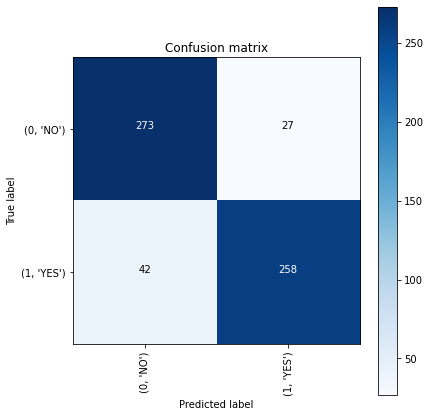

		Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89       300
           1       0.91      0.86      0.88       300

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.88       600
weighted avg       0.89      0.89      0.88       600

--------------------------------------------------------------------------------

------------------------------Fitting SVM on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 93.33%


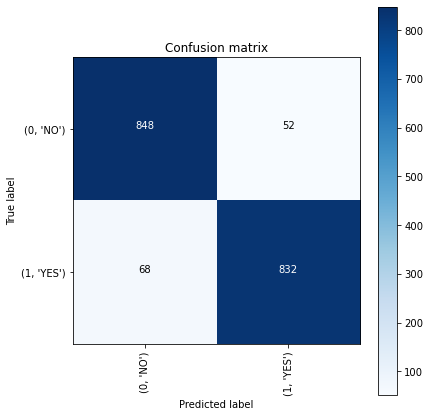

------------------------ Validation Set Metrics------------------------

Accuracy score : 86.17%


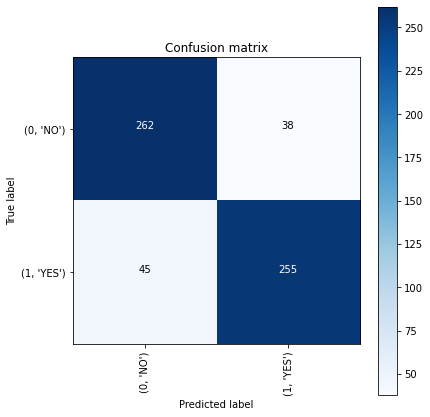

------------------------ Test Set Metrics------------------------

Accuracy score : 87.0%
F1_score : 0.87
Kappa Score : 0.74 
Recall score: 0.87
Precision score : 0.87
ROC AUC score : 0.8700000000000001


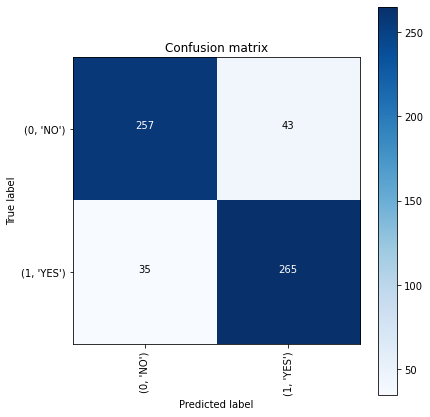

		Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87       300
           1       0.86      0.88      0.87       300

    accuracy                           0.87       600
   macro avg       0.87      0.87      0.87       600
weighted avg       0.87      0.87      0.87       600

--------------------------------------------------------------------------------

------------------------------Fitting Random Forest Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


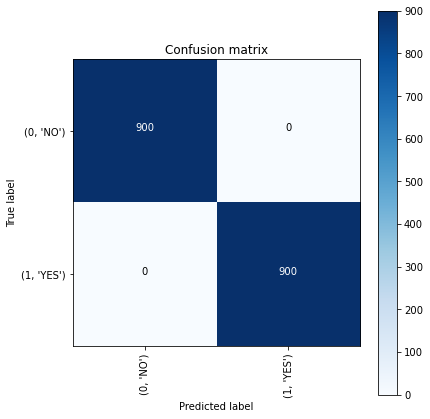

------------------------ Validation Set Metrics------------------------

Accuracy score : 84.83000000000001%


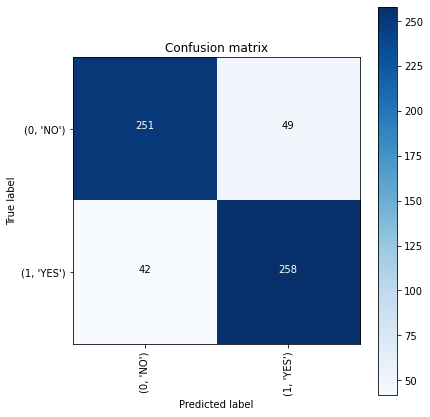

------------------------ Test Set Metrics------------------------

Accuracy score : 84.33%
F1_score : 0.84
Kappa Score : 0.69 
Recall score: 0.84
Precision score : 0.84
ROC AUC score : 0.8433333333333333


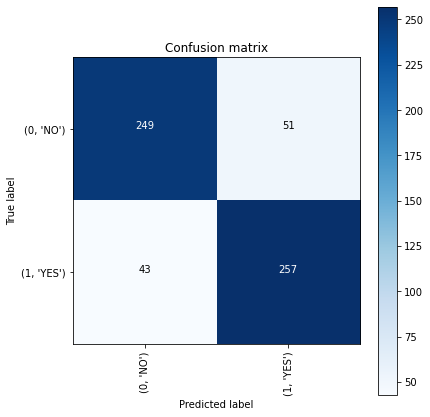

		Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84       300
           1       0.83      0.86      0.85       300

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600

--------------------------------------------------------------------------------

------------------------------Fitting AdaBoost Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 85.06%


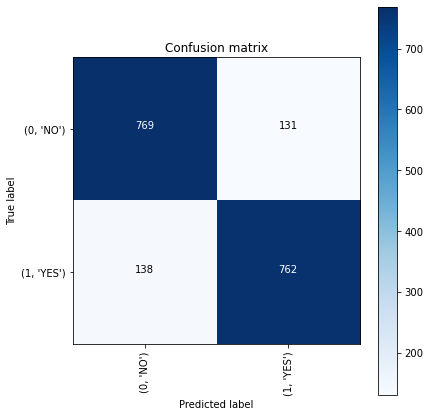

------------------------ Validation Set Metrics------------------------

Accuracy score : 77.33%


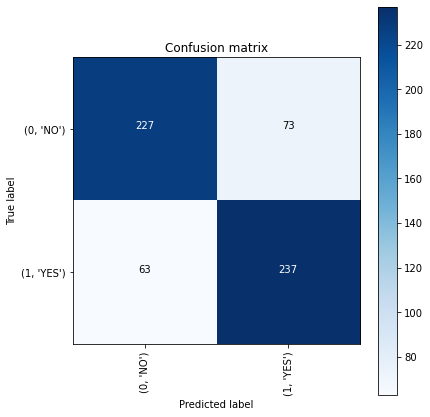

------------------------ Test Set Metrics------------------------

Accuracy score : 77.5%
F1_score : 0.77
Kappa Score : 0.55 
Recall score: 0.78
Precision score : 0.78
ROC AUC score : 0.775


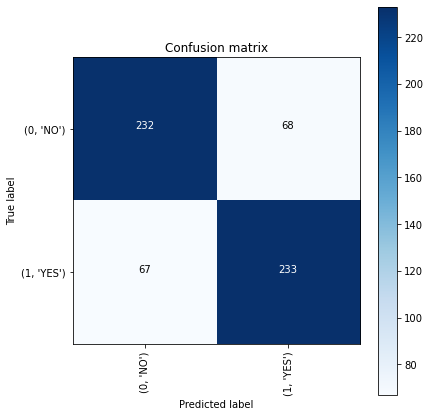

		Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.77      0.77       300
           1       0.77      0.78      0.78       300

    accuracy                           0.78       600
   macro avg       0.78      0.77      0.77       600
weighted avg       0.78      0.78      0.77       600

--------------------------------------------------------------------------------

------------------------------Fitting XGB Classifier on input_data-------------------------------- 
[16:55:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].




------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


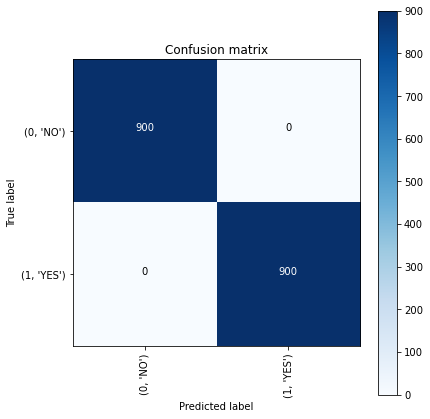

------------------------ Validation Set Metrics------------------------

Accuracy score : 88.33%


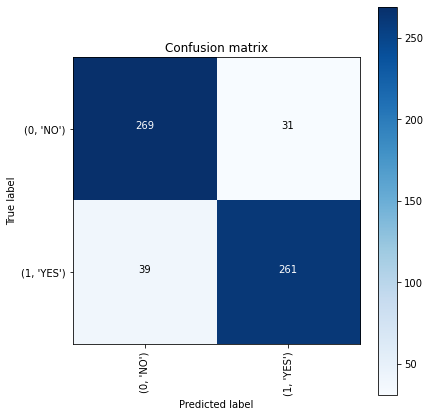

------------------------ Test Set Metrics------------------------

Accuracy score : 85.0%
F1_score : 0.85
Kappa Score : 0.7 
Recall score: 0.85
Precision score : 0.85
ROC AUC score : 0.8499999999999999


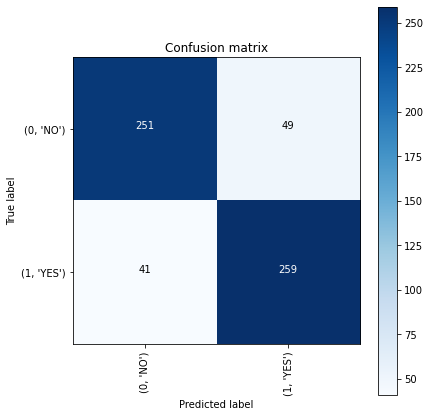

		Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85       300
           1       0.84      0.86      0.85       300

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600

--------------------------------------------------------------------------------

------------------------------Fitting ANN Classifier on input_data-------------------------------- 


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.




------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


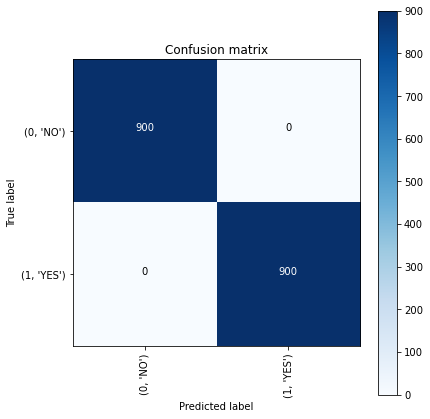

------------------------ Validation Set Metrics------------------------

Accuracy score : 89.83%


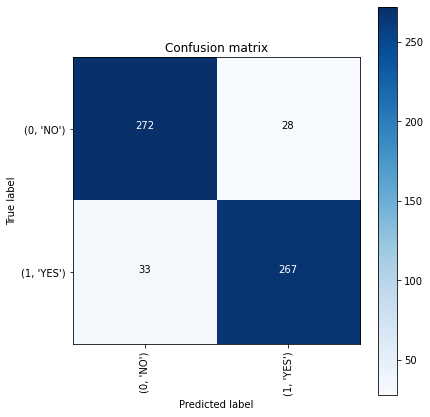

------------------------ Test Set Metrics------------------------

Accuracy score : 88.83%
F1_score : 0.89
Kappa Score : 0.78 
Recall score: 0.89
Precision score : 0.89
ROC AUC score : 0.8883333333333333


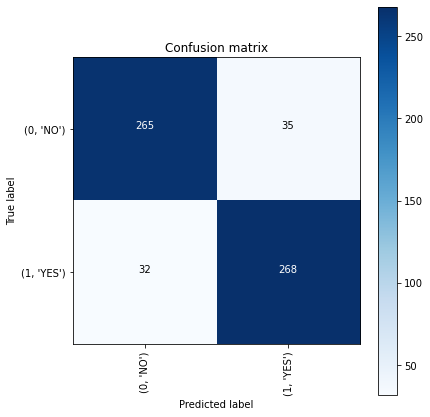

		Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.89       300
           1       0.88      0.89      0.89       300

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600

--------------------------------------------------------------------------------



In [71]:
classifier_comparator(train_features,y_train,val_features,y_val,test_features,y_test,classifier=zipped_clf)

# MobileNet-V2

In [74]:
base_model= MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
predictions = Activation('relu')(x)
#x = Dropout(0.5)(x)
#predictions = Dense(3, activation='softmax')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(X_train_prep)
val_features=model_feat.predict(X_val_prep)
test_features=model_feat.predict(X_test_prep)

9412608/9406464 [==============================] - 0s 0us/step


------------------------------Fitting K Nearest Neighbour Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 84.72%


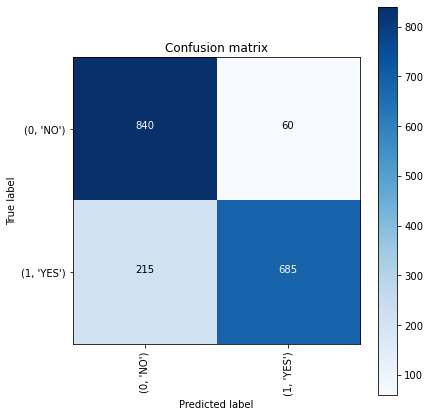

------------------------ Validation Set Metrics------------------------

Accuracy score : 75.33%


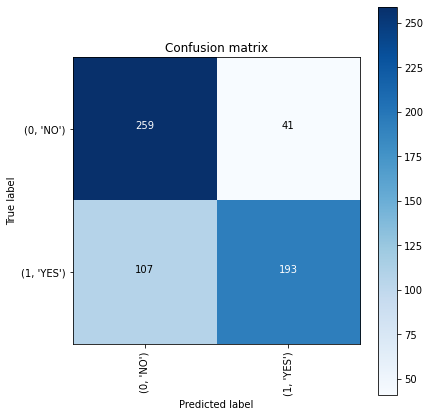

------------------------ Test Set Metrics------------------------

Accuracy score : 74.67%
F1_score : 0.74
Kappa Score : 0.49 
Recall score: 0.75
Precision score : 0.76
ROC AUC score : 0.7466666666666666


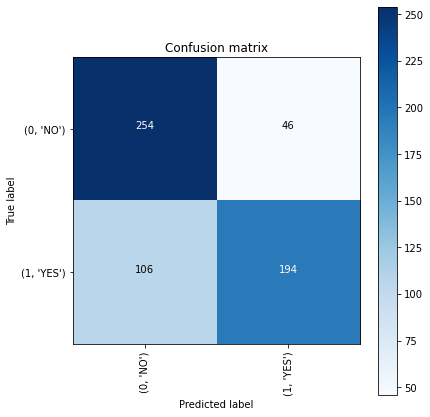

		Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.85      0.77       300
           1       0.81      0.65      0.72       300

    accuracy                           0.75       600
   macro avg       0.76      0.75      0.74       600
weighted avg       0.76      0.75      0.74       600

--------------------------------------------------------------------------------

------------------------------Fitting SVM on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 89.61%


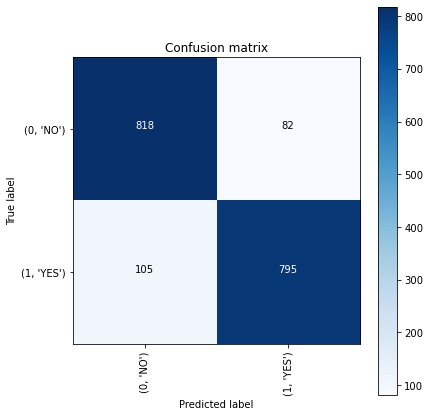

------------------------ Validation Set Metrics------------------------

Accuracy score : 79.5%


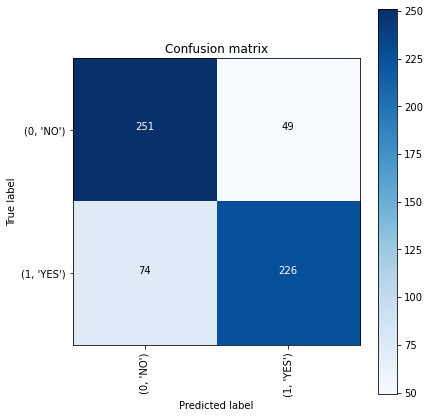

------------------------ Test Set Metrics------------------------

Accuracy score : 76.33%
F1_score : 0.76
Kappa Score : 0.53 
Recall score: 0.76
Precision score : 0.76
ROC AUC score : 0.7633333333333333


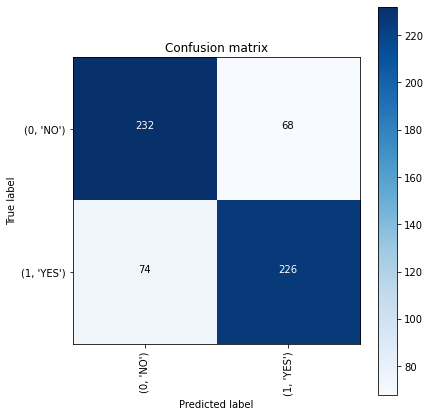

		Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.77      0.77       300
           1       0.77      0.75      0.76       300

    accuracy                           0.76       600
   macro avg       0.76      0.76      0.76       600
weighted avg       0.76      0.76      0.76       600

--------------------------------------------------------------------------------

------------------------------Fitting Random Forest Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


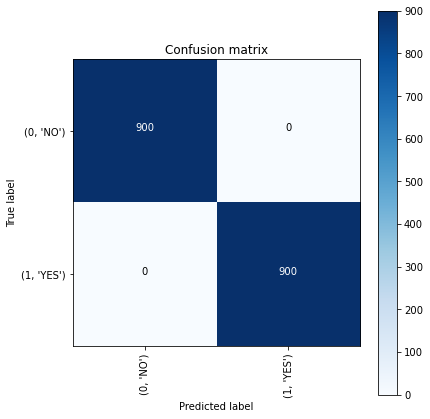

------------------------ Validation Set Metrics------------------------

Accuracy score : 75.83%


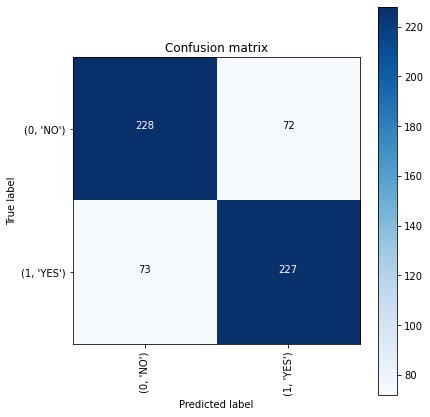

------------------------ Test Set Metrics------------------------

Accuracy score : 76.67%
F1_score : 0.77
Kappa Score : 0.53 
Recall score: 0.77
Precision score : 0.77
ROC AUC score : 0.7666666666666666


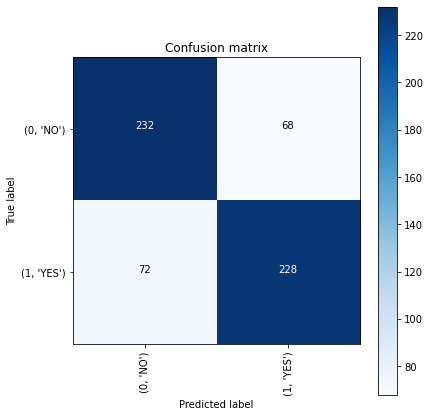

		Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.77      0.77       300
           1       0.77      0.76      0.77       300

    accuracy                           0.77       600
   macro avg       0.77      0.77      0.77       600
weighted avg       0.77      0.77      0.77       600

--------------------------------------------------------------------------------

------------------------------Fitting AdaBoost Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 79.39%


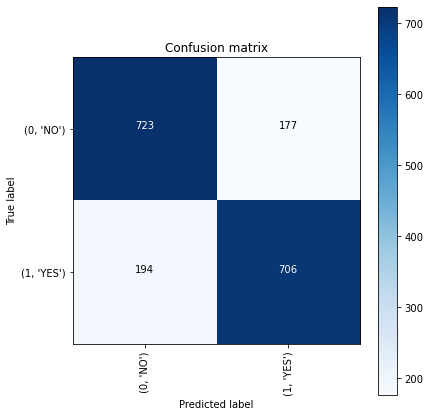

------------------------ Validation Set Metrics------------------------

Accuracy score : 74.0%


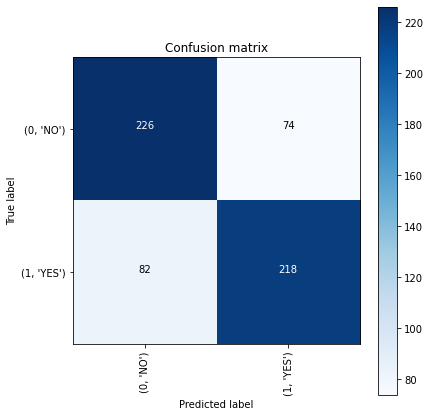

------------------------ Test Set Metrics------------------------

Accuracy score : 69.0%
F1_score : 0.69
Kappa Score : 0.38 
Recall score: 0.69
Precision score : 0.69
ROC AUC score : 0.69


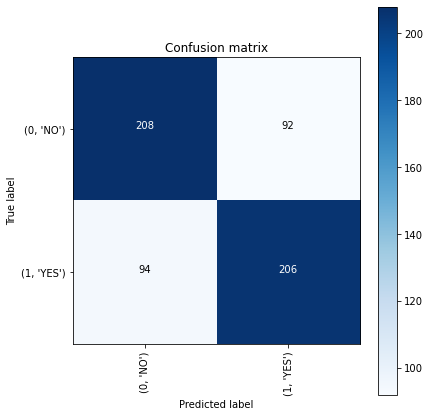

		Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.69      0.69       300
           1       0.69      0.69      0.69       300

    accuracy                           0.69       600
   macro avg       0.69      0.69      0.69       600
weighted avg       0.69      0.69      0.69       600

--------------------------------------------------------------------------------

------------------------------Fitting XGB Classifier on input_data-------------------------------- 
[16:56:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].




------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


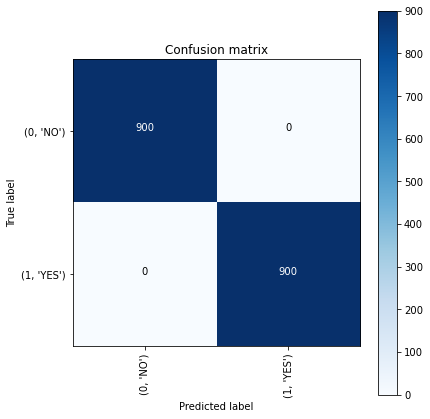

------------------------ Validation Set Metrics------------------------

Accuracy score : 78.0%


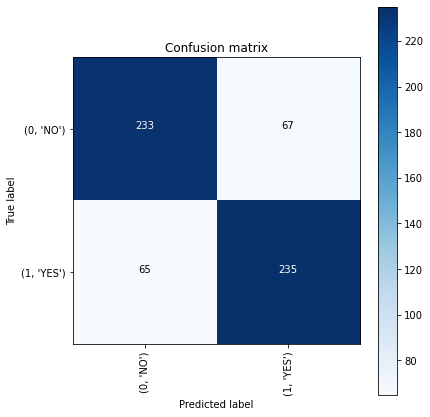

------------------------ Test Set Metrics------------------------

Accuracy score : 79.0%
F1_score : 0.79
Kappa Score : 0.58 
Recall score: 0.79
Precision score : 0.79
ROC AUC score : 0.7899999999999999


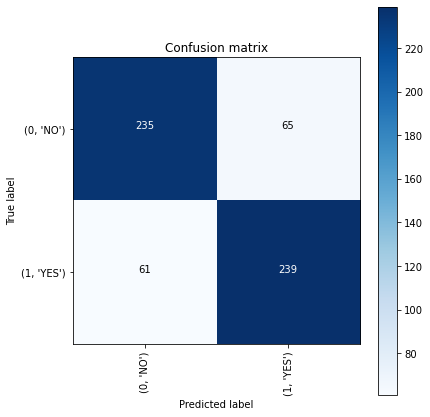

		Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.79       300
           1       0.79      0.80      0.79       300

    accuracy                           0.79       600
   macro avg       0.79      0.79      0.79       600
weighted avg       0.79      0.79      0.79       600

--------------------------------------------------------------------------------

------------------------------Fitting ANN Classifier on input_data-------------------------------- 


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.




------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


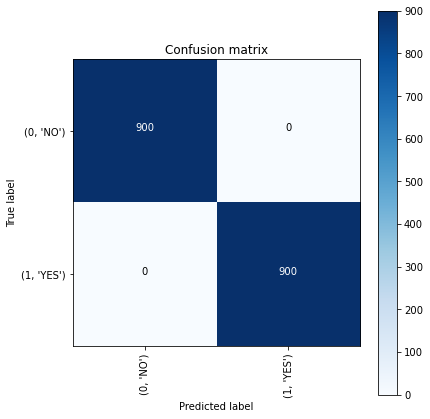

------------------------ Validation Set Metrics------------------------

Accuracy score : 81.67%


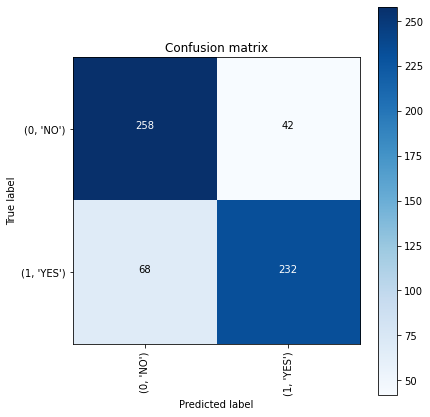

------------------------ Test Set Metrics------------------------

Accuracy score : 77.5%
F1_score : 0.77
Kappa Score : 0.55 
Recall score: 0.78
Precision score : 0.78
ROC AUC score : 0.775


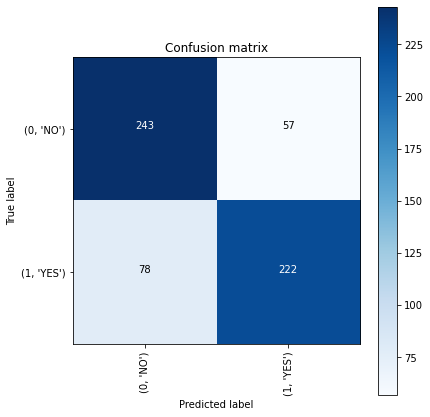

		Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.81      0.78       300
           1       0.80      0.74      0.77       300

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.77       600
weighted avg       0.78      0.78      0.77       600

--------------------------------------------------------------------------------



In [75]:
classifier_comparator(train_features,y_train,val_features,y_val,test_features,y_test,classifier=zipped_clf)

# MobileNet

In [78]:
base_model= MobileNet(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
predictions = Activation('relu')(x)
#x = Dropout(0.5)(x)
#predictions = Dense(3, activation='softmax')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(X_train_prep)
val_features=model_feat.predict(X_val_prep)
test_features=model_feat.predict(X_test_prep)

17227776/17225924 [==============================] - 0s 0us/step


------------------------------Fitting K Nearest Neighbour Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 83.44%


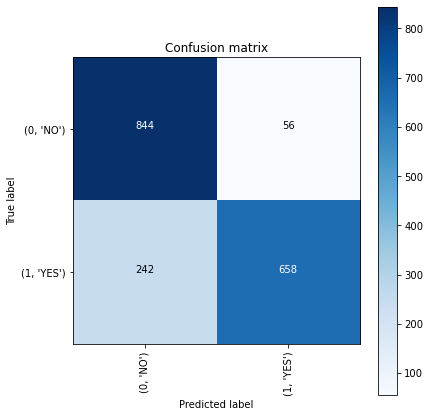

------------------------ Validation Set Metrics------------------------

Accuracy score : 73.0%


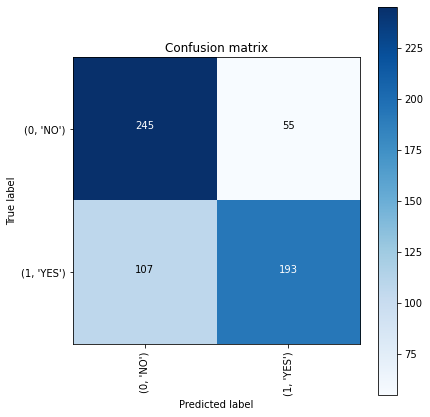

------------------------ Test Set Metrics------------------------

Accuracy score : 72.67%
F1_score : 0.72
Kappa Score : 0.45 
Recall score: 0.73
Precision score : 0.74
ROC AUC score : 0.7266666666666667


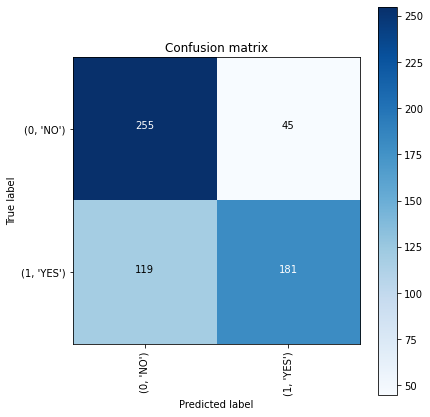

		Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.85      0.76       300
           1       0.80      0.60      0.69       300

    accuracy                           0.73       600
   macro avg       0.74      0.73      0.72       600
weighted avg       0.74      0.73      0.72       600

--------------------------------------------------------------------------------

------------------------------Fitting SVM on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 88.89%


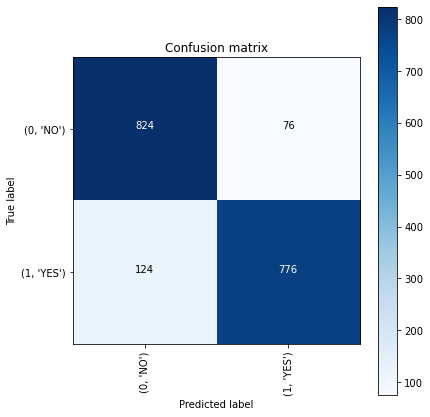

------------------------ Validation Set Metrics------------------------

Accuracy score : 77.5%


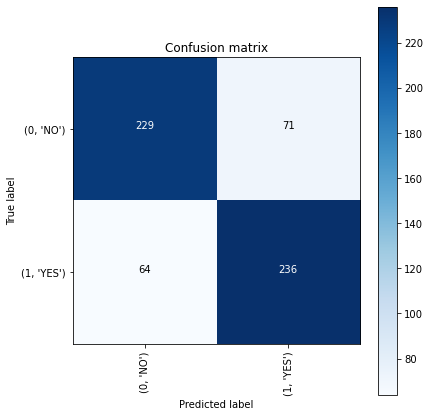

------------------------ Test Set Metrics------------------------

Accuracy score : 78.5%
F1_score : 0.78
Kappa Score : 0.57 
Recall score: 0.78
Precision score : 0.79
ROC AUC score : 0.7849999999999999


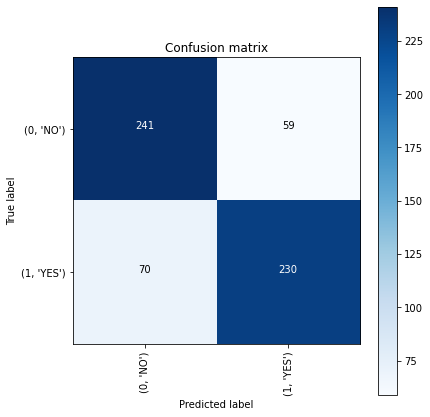

		Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.80      0.79       300
           1       0.80      0.77      0.78       300

    accuracy                           0.79       600
   macro avg       0.79      0.79      0.78       600
weighted avg       0.79      0.79      0.78       600

--------------------------------------------------------------------------------

------------------------------Fitting Random Forest Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


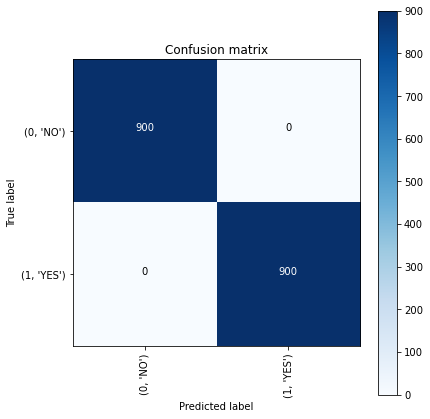

------------------------ Validation Set Metrics------------------------

Accuracy score : 76.17%


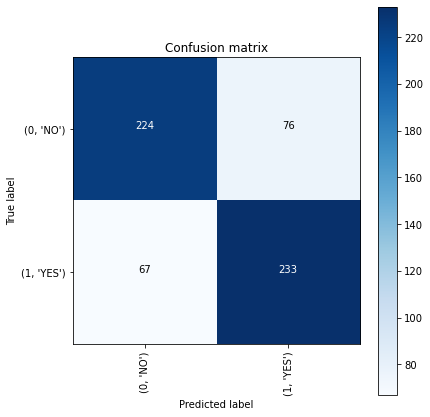

------------------------ Test Set Metrics------------------------

Accuracy score : 77.0%
F1_score : 0.77
Kappa Score : 0.54 
Recall score: 0.77
Precision score : 0.77
ROC AUC score : 0.77


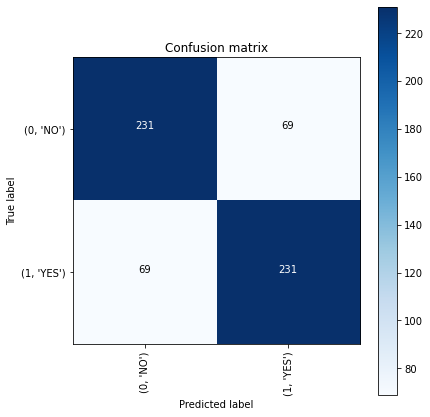

		Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77       300
           1       0.77      0.77      0.77       300

    accuracy                           0.77       600
   macro avg       0.77      0.77      0.77       600
weighted avg       0.77      0.77      0.77       600

--------------------------------------------------------------------------------

------------------------------Fitting AdaBoost Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 77.06%


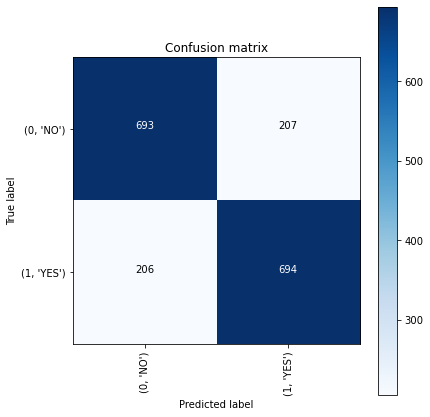

------------------------ Validation Set Metrics------------------------

Accuracy score : 68.83%


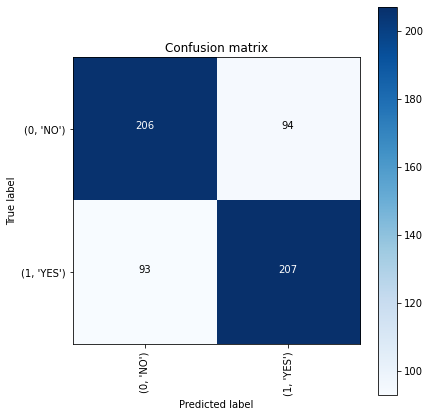

------------------------ Test Set Metrics------------------------

Accuracy score : 67.67%
F1_score : 0.68
Kappa Score : 0.35 
Recall score: 0.68
Precision score : 0.68
ROC AUC score : 0.6766666666666667


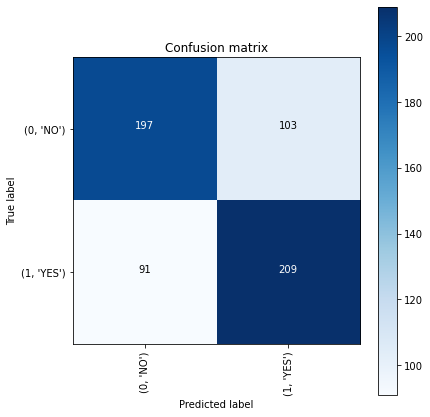

		Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.66      0.67       300
           1       0.67      0.70      0.68       300

    accuracy                           0.68       600
   macro avg       0.68      0.68      0.68       600
weighted avg       0.68      0.68      0.68       600

--------------------------------------------------------------------------------

------------------------------Fitting XGB Classifier on input_data-------------------------------- 
[16:57:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].




------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


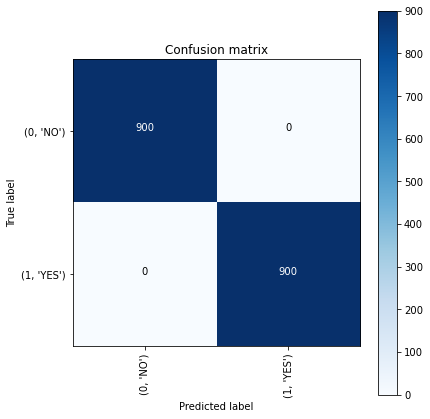

------------------------ Validation Set Metrics------------------------

Accuracy score : 77.5%


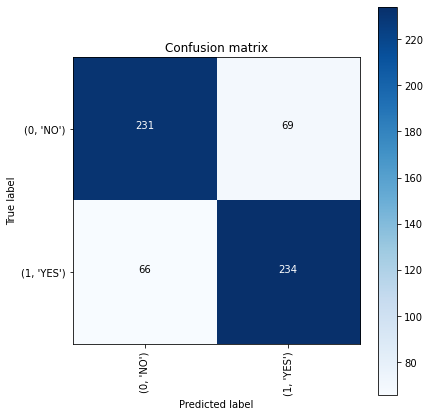

------------------------ Test Set Metrics------------------------

Accuracy score : 76.67%
F1_score : 0.77
Kappa Score : 0.53 
Recall score: 0.77
Precision score : 0.77
ROC AUC score : 0.7666666666666666


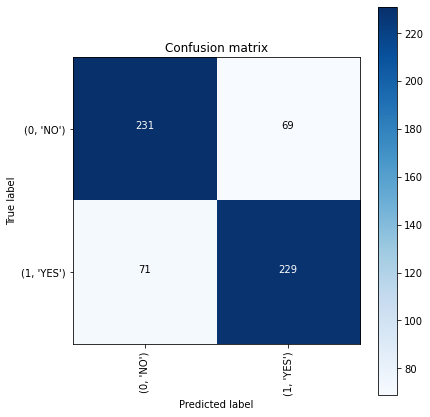

		Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.77      0.77       300
           1       0.77      0.76      0.77       300

    accuracy                           0.77       600
   macro avg       0.77      0.77      0.77       600
weighted avg       0.77      0.77      0.77       600

--------------------------------------------------------------------------------

------------------------------Fitting ANN Classifier on input_data-------------------------------- 


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.




------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


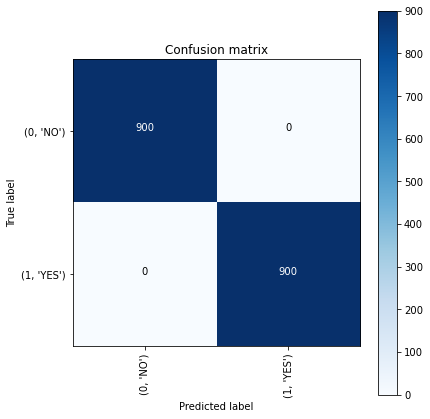

------------------------ Validation Set Metrics------------------------

Accuracy score : 78.83%


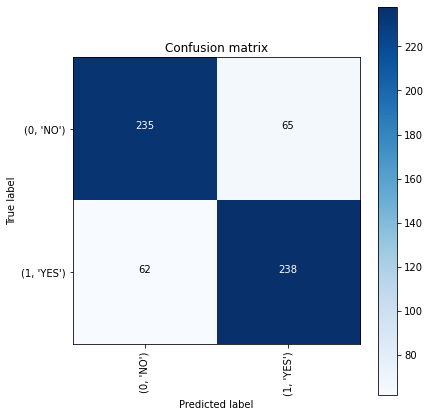

------------------------ Test Set Metrics------------------------

Accuracy score : 79.83%
F1_score : 0.8
Kappa Score : 0.6 
Recall score: 0.8
Precision score : 0.8
ROC AUC score : 0.7983333333333333


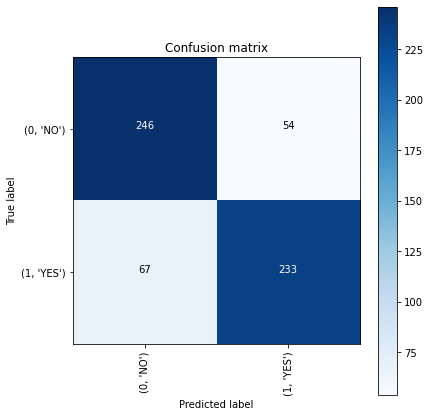

		Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.82      0.80       300
           1       0.81      0.78      0.79       300

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600

--------------------------------------------------------------------------------



In [79]:
classifier_comparator(train_features,y_train,val_features,y_val,test_features,y_test,classifier=zipped_clf)

# Inception-V3

In [82]:
base_model= InceptionV3(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
predictions = Activation('relu')(x)
#x = Dropout(0.5)(x)
#predictions = Dense(3, activation='softmax')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(X_train_prep)
val_features=model_feat.predict(X_val_prep)
test_features=model_feat.predict(X_test_prep)

87916544/87910968 [==============================] - 1s 0us/step


------------------------------Fitting K Nearest Neighbour Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 85.33%


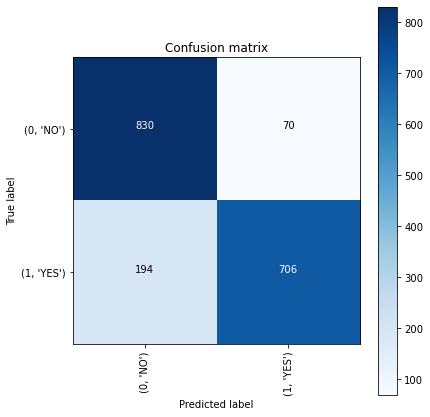

------------------------ Validation Set Metrics------------------------

Accuracy score : 71.83%


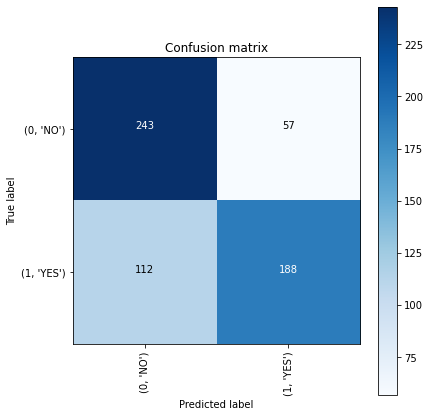

------------------------ Test Set Metrics------------------------

Accuracy score : 76.17%
F1_score : 0.76
Kappa Score : 0.52 
Recall score: 0.76
Precision score : 0.76
ROC AUC score : 0.7616666666666665


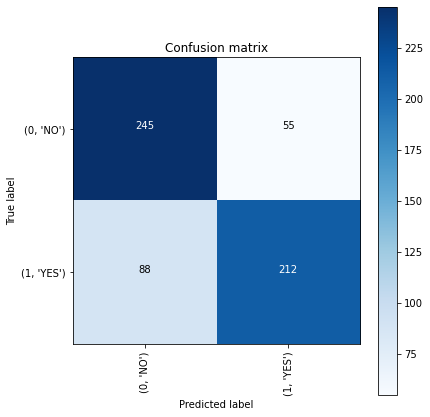

		Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.82      0.77       300
           1       0.79      0.71      0.75       300

    accuracy                           0.76       600
   macro avg       0.76      0.76      0.76       600
weighted avg       0.76      0.76      0.76       600

--------------------------------------------------------------------------------

------------------------------Fitting SVM on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 84.78%


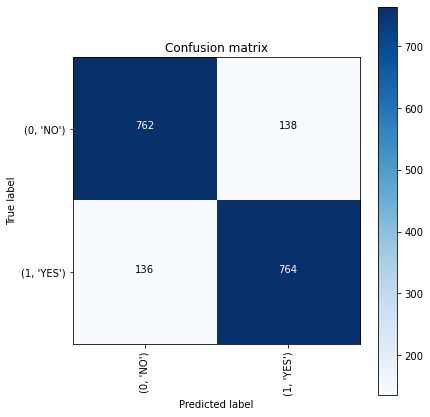

------------------------ Validation Set Metrics------------------------

Accuracy score : 73.83%


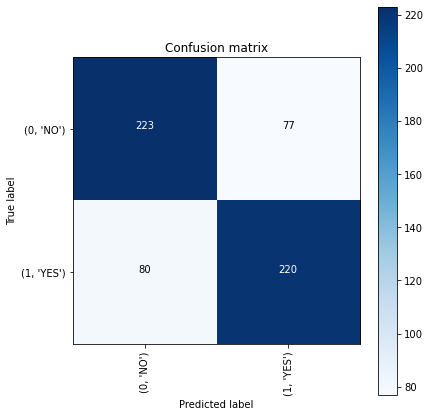

------------------------ Test Set Metrics------------------------

Accuracy score : 74.83%
F1_score : 0.75
Kappa Score : 0.5 
Recall score: 0.75
Precision score : 0.75
ROC AUC score : 0.7483333333333333


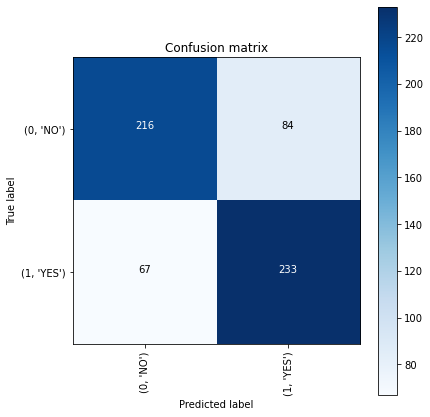

		Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.72      0.74       300
           1       0.74      0.78      0.76       300

    accuracy                           0.75       600
   macro avg       0.75      0.75      0.75       600
weighted avg       0.75      0.75      0.75       600

--------------------------------------------------------------------------------

------------------------------Fitting Random Forest Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


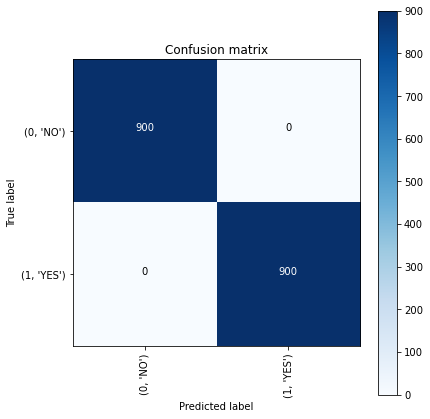

------------------------ Validation Set Metrics------------------------

Accuracy score : 73.83%


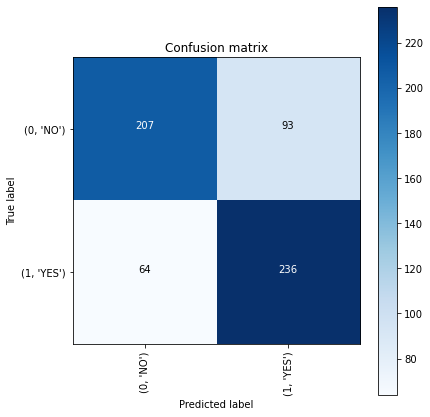

------------------------ Test Set Metrics------------------------

Accuracy score : 77.83%
F1_score : 0.78
Kappa Score : 0.56 
Recall score: 0.78
Precision score : 0.78
ROC AUC score : 0.7783333333333333


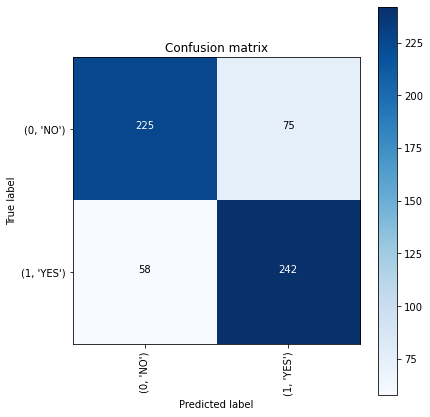

		Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.75      0.77       300
           1       0.76      0.81      0.78       300

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.78      0.78      0.78       600

--------------------------------------------------------------------------------

------------------------------Fitting AdaBoost Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 75.61%


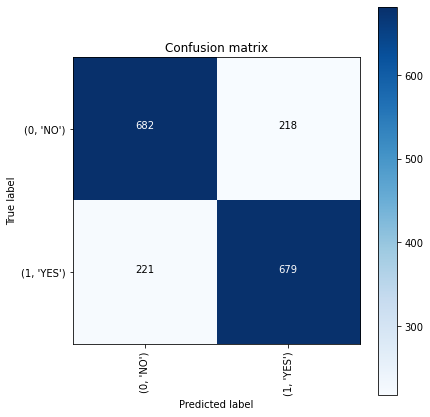

------------------------ Validation Set Metrics------------------------

Accuracy score : 60.67%


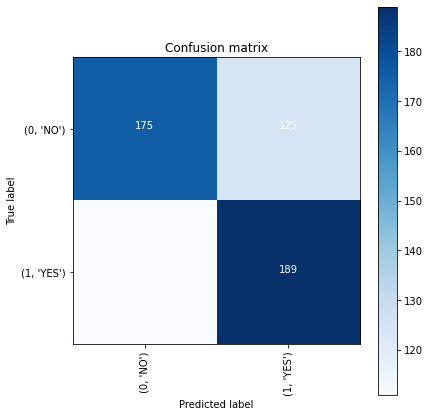

------------------------ Test Set Metrics------------------------

Accuracy score : 63.83%
F1_score : 0.64
Kappa Score : 0.28 
Recall score: 0.64
Precision score : 0.64
ROC AUC score : 0.6383333333333334


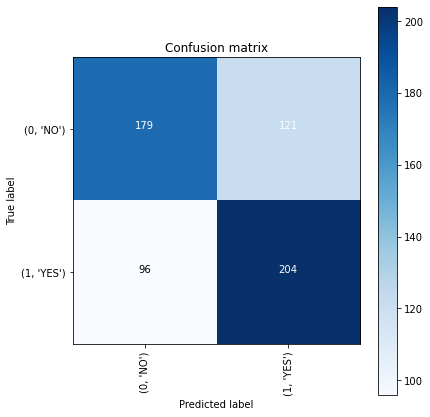

		Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.60      0.62       300
           1       0.63      0.68      0.65       300

    accuracy                           0.64       600
   macro avg       0.64      0.64      0.64       600
weighted avg       0.64      0.64      0.64       600

--------------------------------------------------------------------------------

------------------------------Fitting XGB Classifier on input_data-------------------------------- 
[16:58:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].




------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


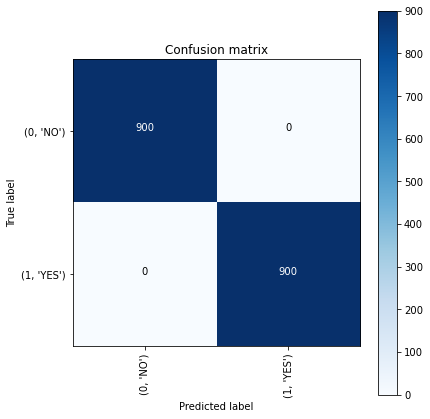

------------------------ Validation Set Metrics------------------------

Accuracy score : 73.67%


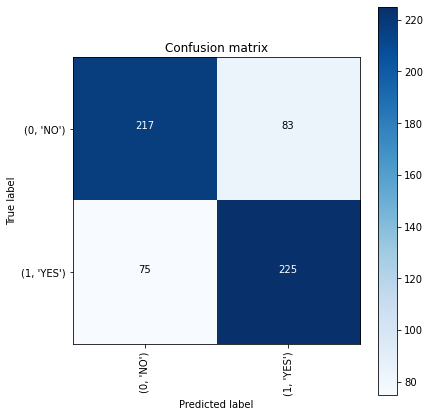

------------------------ Test Set Metrics------------------------

Accuracy score : 75.33%
F1_score : 0.75
Kappa Score : 0.51 
Recall score: 0.75
Precision score : 0.75
ROC AUC score : 0.7533333333333334


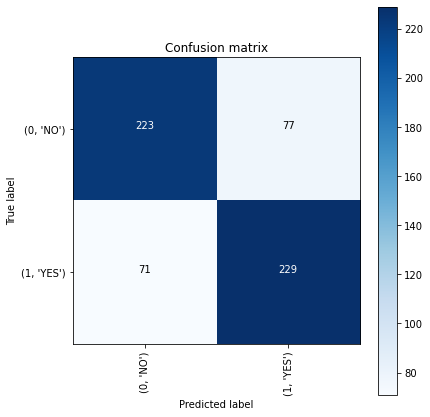

		Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.74      0.75       300
           1       0.75      0.76      0.76       300

    accuracy                           0.75       600
   macro avg       0.75      0.75      0.75       600
weighted avg       0.75      0.75      0.75       600

--------------------------------------------------------------------------------

------------------------------Fitting ANN Classifier on input_data-------------------------------- 


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.




------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


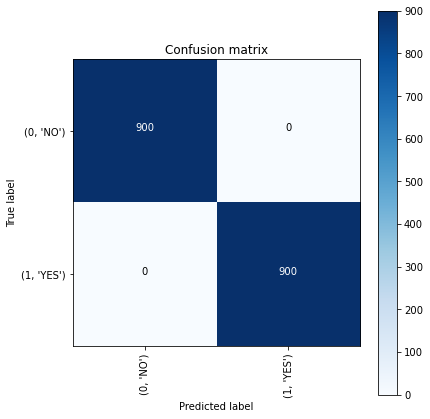

------------------------ Validation Set Metrics------------------------

Accuracy score : 74.17%


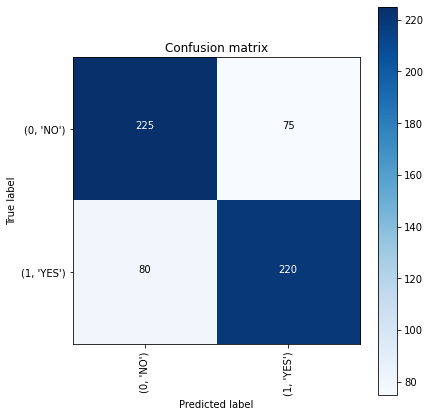

------------------------ Test Set Metrics------------------------

Accuracy score : 76.83%
F1_score : 0.77
Kappa Score : 0.54 
Recall score: 0.77
Precision score : 0.77
ROC AUC score : 0.7683333333333333


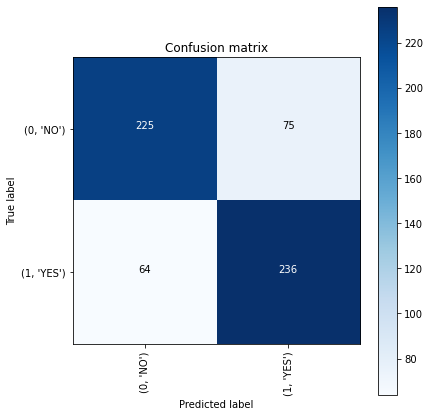

		Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.76       300
           1       0.76      0.79      0.77       300

    accuracy                           0.77       600
   macro avg       0.77      0.77      0.77       600
weighted avg       0.77      0.77      0.77       600

--------------------------------------------------------------------------------



In [83]:
classifier_comparator(train_features,y_train,val_features,y_val,test_features,y_test,classifier=zipped_clf)

# InceptionResNet-V2

In [86]:
base_model= InceptionResNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
predictions = Activation('relu')(x)
#x = Dropout(0.5)(x)
#predictions = Dense(3, activation='softmax')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(X_train_prep)
val_features=model_feat.predict(X_val_prep)
test_features=model_feat.predict(X_test_prep)

219062272/219055592 [==============================] - 2s 0us/step


------------------------------Fitting K Nearest Neighbour Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 83.44%


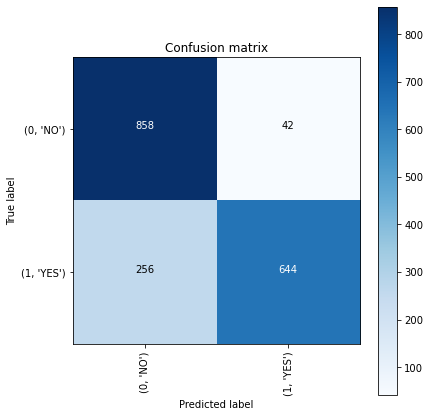

------------------------ Validation Set Metrics------------------------

Accuracy score : 75.33%


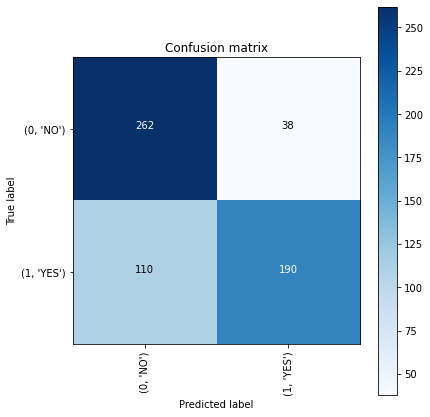

------------------------ Test Set Metrics------------------------

Accuracy score : 74.33%
F1_score : 0.74
Kappa Score : 0.49 
Recall score: 0.74
Precision score : 0.78
ROC AUC score : 0.7433333333333333


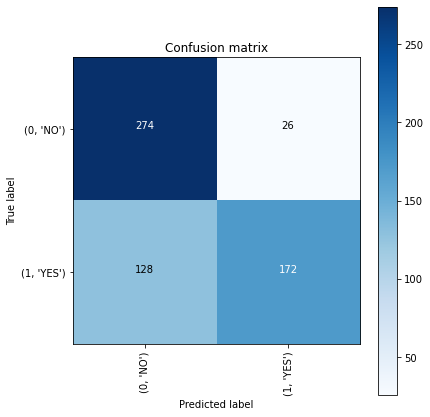

		Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.91      0.78       300
           1       0.87      0.57      0.69       300

    accuracy                           0.74       600
   macro avg       0.78      0.74      0.74       600
weighted avg       0.78      0.74      0.74       600

--------------------------------------------------------------------------------

------------------------------Fitting SVM on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 70.11%


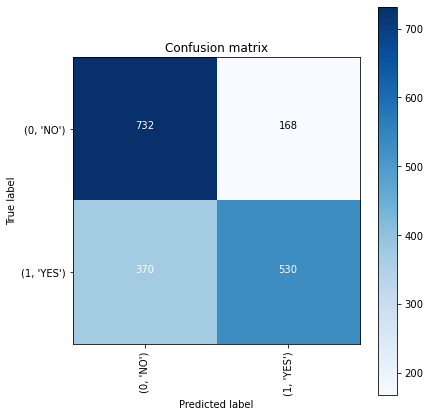

------------------------ Validation Set Metrics------------------------

Accuracy score : 68.5%


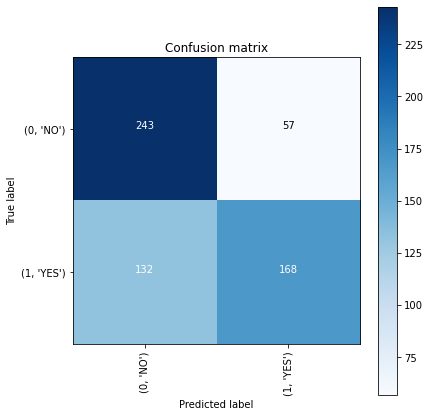

------------------------ Test Set Metrics------------------------

Accuracy score : 65.67%
F1_score : 0.65
Kappa Score : 0.31 
Recall score: 0.66
Precision score : 0.67
ROC AUC score : 0.6566666666666666


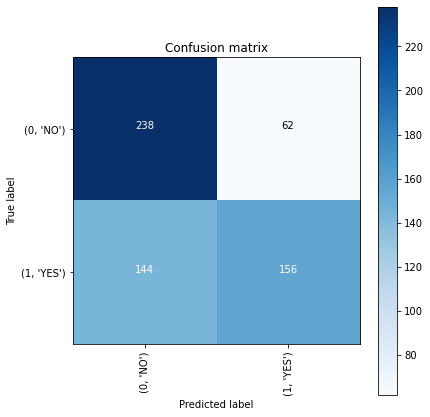

		Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.79      0.70       300
           1       0.72      0.52      0.60       300

    accuracy                           0.66       600
   macro avg       0.67      0.66      0.65       600
weighted avg       0.67      0.66      0.65       600

--------------------------------------------------------------------------------

------------------------------Fitting Random Forest Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


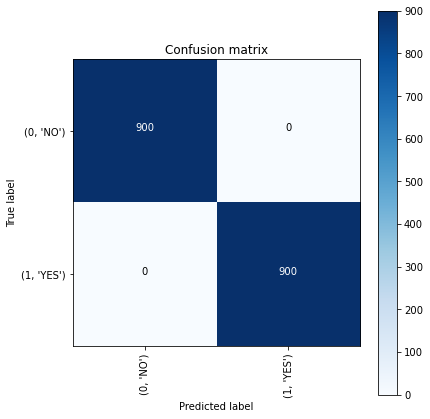

------------------------ Validation Set Metrics------------------------

Accuracy score : 82.33%


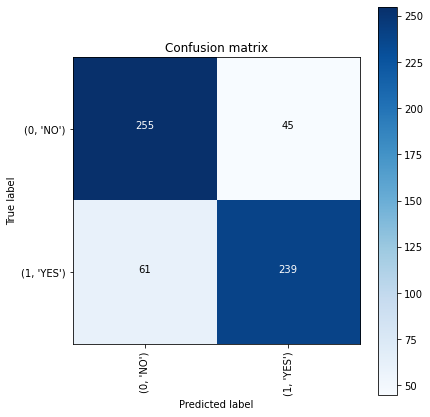

------------------------ Test Set Metrics------------------------

Accuracy score : 85.83%
F1_score : 0.86
Kappa Score : 0.72 
Recall score: 0.86
Precision score : 0.86
ROC AUC score : 0.8583333333333333


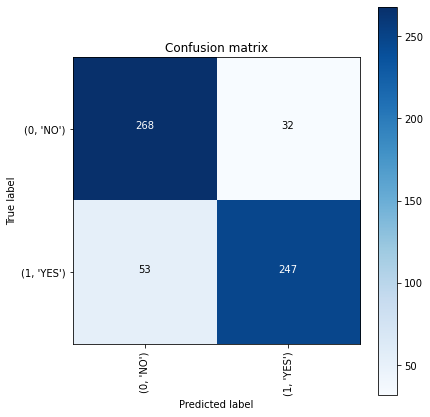

		Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86       300
           1       0.89      0.82      0.85       300

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600

--------------------------------------------------------------------------------

------------------------------Fitting AdaBoost Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 79.39%


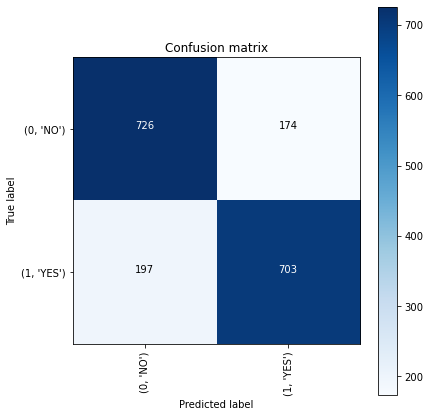

------------------------ Validation Set Metrics------------------------

Accuracy score : 70.67%


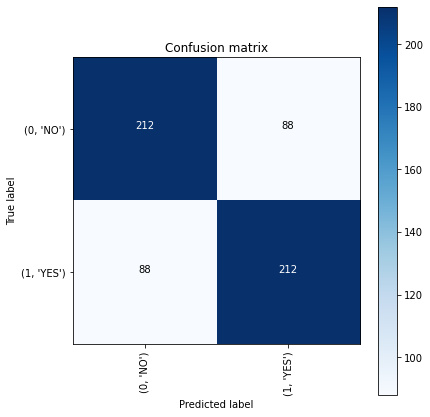

------------------------ Test Set Metrics------------------------

Accuracy score : 69.5%
F1_score : 0.69
Kappa Score : 0.39 
Recall score: 0.7
Precision score : 0.7
ROC AUC score : 0.695


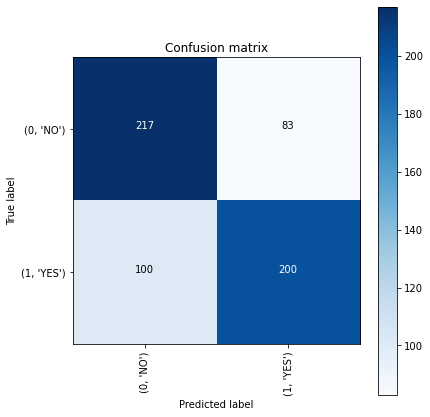

		Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.72      0.70       300
           1       0.71      0.67      0.69       300

    accuracy                           0.69       600
   macro avg       0.70      0.70      0.69       600
weighted avg       0.70      0.69      0.69       600

--------------------------------------------------------------------------------

------------------------------Fitting XGB Classifier on input_data-------------------------------- 
[16:58:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].




------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


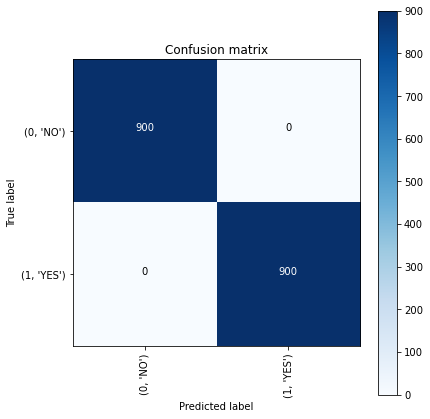

------------------------ Validation Set Metrics------------------------

Accuracy score : 81.33%


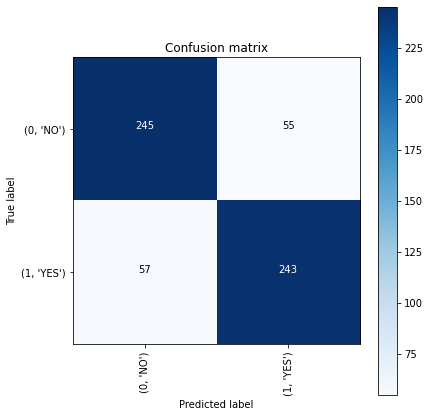

------------------------ Test Set Metrics------------------------

Accuracy score : 83.83%
F1_score : 0.84
Kappa Score : 0.68 
Recall score: 0.84
Precision score : 0.84
ROC AUC score : 0.8383333333333334


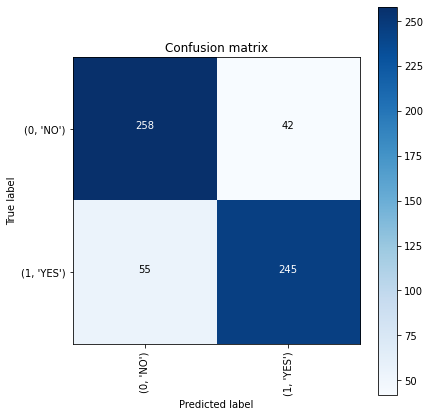

		Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84       300
           1       0.85      0.82      0.83       300

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600

--------------------------------------------------------------------------------

------------------------------Fitting ANN Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 80.61%


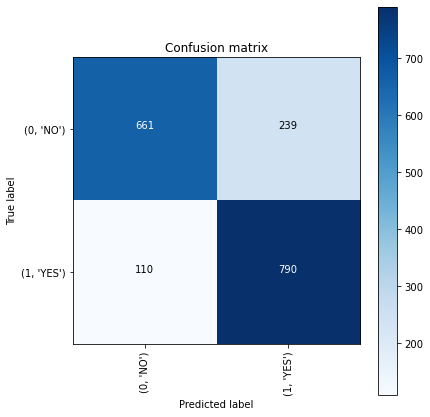

------------------------ Validation Set Metrics------------------------

Accuracy score : 74.67%


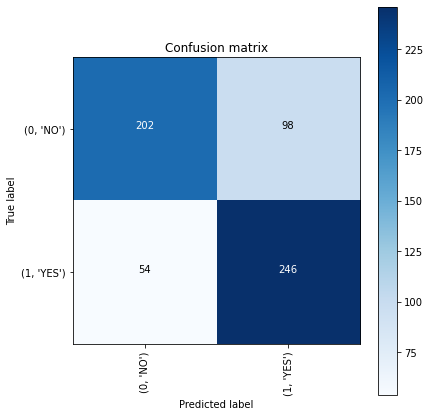

------------------------ Test Set Metrics------------------------

Accuracy score : 73.0%
F1_score : 0.73
Kappa Score : 0.46 
Recall score: 0.73
Precision score : 0.73
ROC AUC score : 0.73


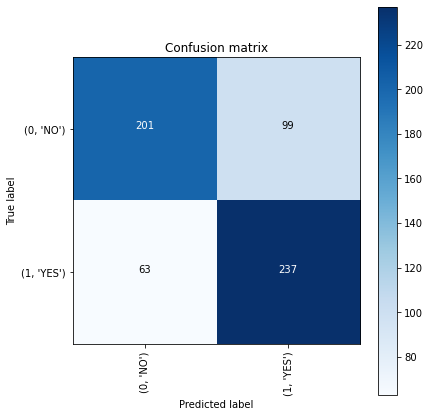

		Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.67      0.71       300
           1       0.71      0.79      0.75       300

    accuracy                           0.73       600
   macro avg       0.73      0.73      0.73       600
weighted avg       0.73      0.73      0.73       600

--------------------------------------------------------------------------------



In [87]:
classifier_comparator(train_features,y_train,val_features,y_val,test_features,y_test,classifier=zipped_clf)

# DenseNet-169

In [90]:
base_model= DenseNet169(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
predictions = Activation('relu')(x)
#x = Dropout(0.5)(x)
#predictions = Dense(3, activation='softmax')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(X_train_prep)
val_features=model_feat.predict(X_val_prep)
test_features=model_feat.predict(X_test_prep)

51879936/51877672 [==============================] - 0s 0us/step


------------------------------Fitting K Nearest Neighbour Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 86.39%


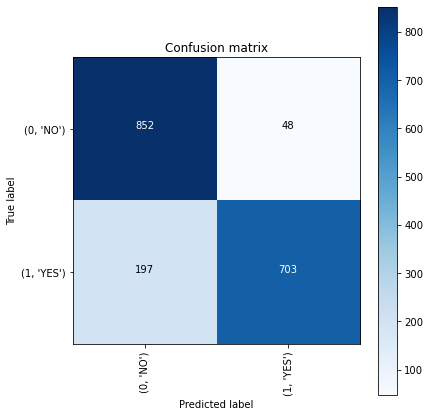

------------------------ Validation Set Metrics------------------------

Accuracy score : 77.17%


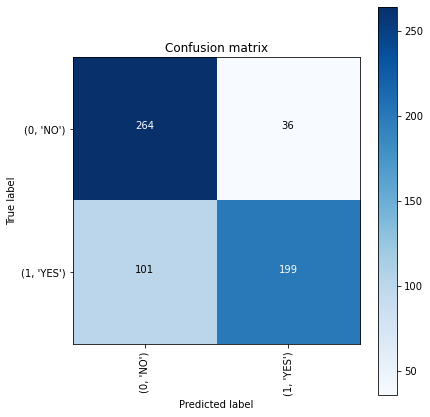

------------------------ Test Set Metrics------------------------

Accuracy score : 81.0%
F1_score : 0.81
Kappa Score : 0.62 
Recall score: 0.81
Precision score : 0.83
ROC AUC score : 0.81


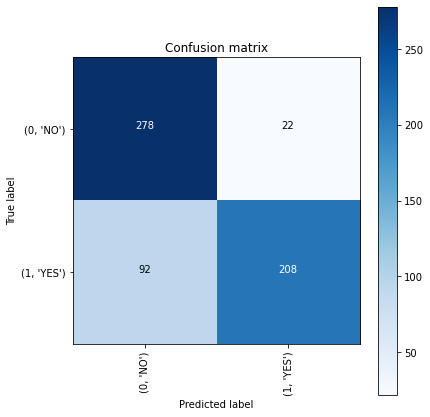

		Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.93      0.83       300
           1       0.90      0.69      0.78       300

    accuracy                           0.81       600
   macro avg       0.83      0.81      0.81       600
weighted avg       0.83      0.81      0.81       600

--------------------------------------------------------------------------------

------------------------------Fitting SVM on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 80.0%


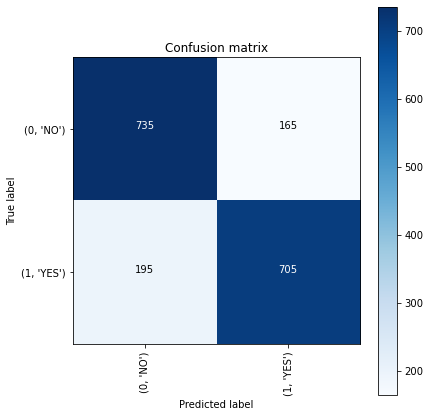

------------------------ Validation Set Metrics------------------------

Accuracy score : 76.17%


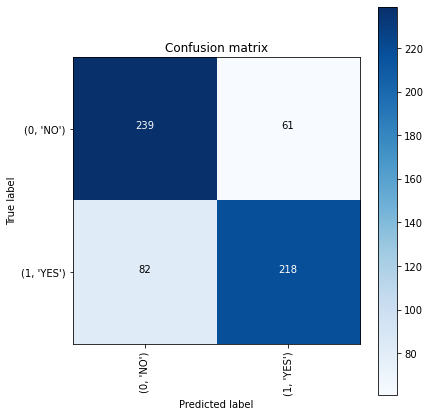

------------------------ Test Set Metrics------------------------

Accuracy score : 76.0%
F1_score : 0.76
Kappa Score : 0.52 
Recall score: 0.76
Precision score : 0.76
ROC AUC score : 0.76


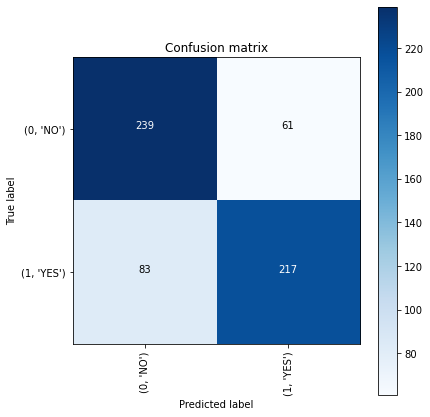

		Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.80      0.77       300
           1       0.78      0.72      0.75       300

    accuracy                           0.76       600
   macro avg       0.76      0.76      0.76       600
weighted avg       0.76      0.76      0.76       600

--------------------------------------------------------------------------------

------------------------------Fitting Random Forest Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


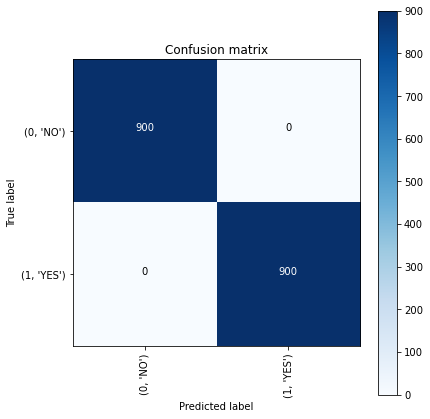

------------------------ Validation Set Metrics------------------------

Accuracy score : 81.0%


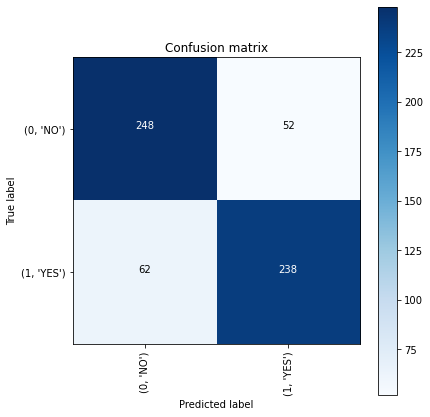

------------------------ Test Set Metrics------------------------

Accuracy score : 82.17%
F1_score : 0.82
Kappa Score : 0.64 
Recall score: 0.82
Precision score : 0.82
ROC AUC score : 0.8216666666666667


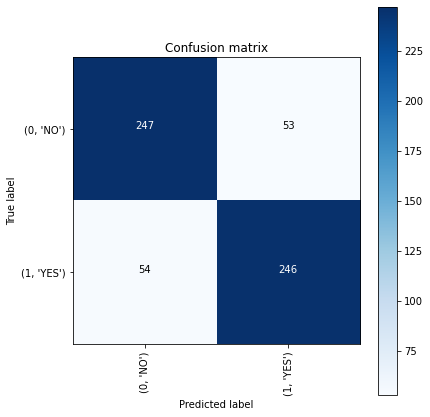

		Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82       300
           1       0.82      0.82      0.82       300

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600

--------------------------------------------------------------------------------

------------------------------Fitting AdaBoost Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 79.22%


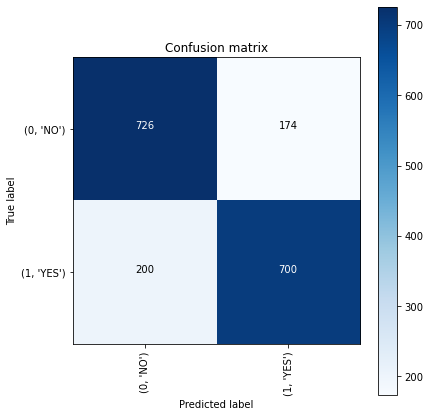

------------------------ Validation Set Metrics------------------------

Accuracy score : 69.83%


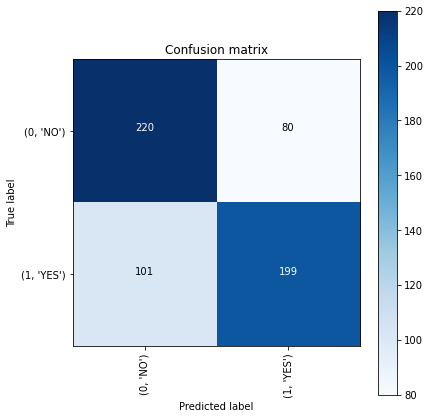

------------------------ Test Set Metrics------------------------

Accuracy score : 72.5%
F1_score : 0.72
Kappa Score : 0.45 
Recall score: 0.72
Precision score : 0.73
ROC AUC score : 0.7249999999999999


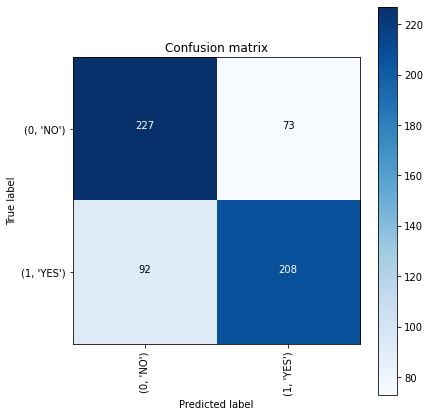

		Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.76      0.73       300
           1       0.74      0.69      0.72       300

    accuracy                           0.73       600
   macro avg       0.73      0.73      0.72       600
weighted avg       0.73      0.72      0.72       600

--------------------------------------------------------------------------------

------------------------------Fitting XGB Classifier on input_data-------------------------------- 
[17:00:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].




------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


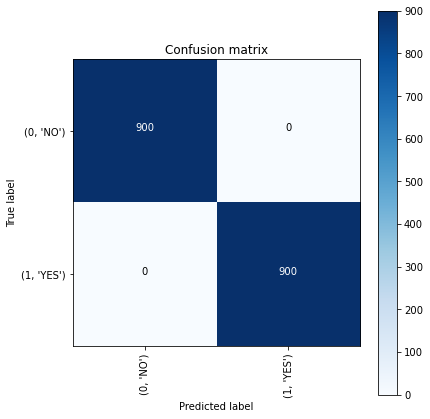

------------------------ Validation Set Metrics------------------------

Accuracy score : 82.17%


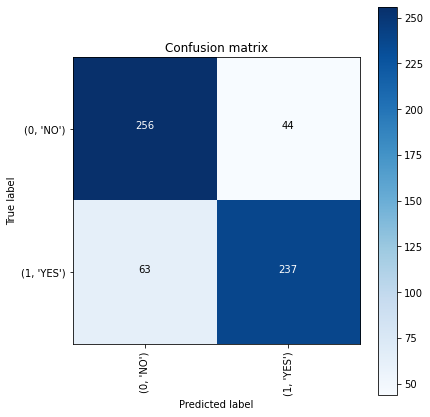

------------------------ Test Set Metrics------------------------

Accuracy score : 82.83%
F1_score : 0.83
Kappa Score : 0.66 
Recall score: 0.83
Precision score : 0.83
ROC AUC score : 0.8283333333333334


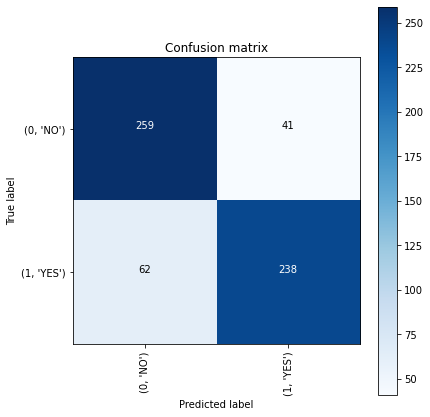

		Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83       300
           1       0.85      0.79      0.82       300

    accuracy                           0.83       600
   macro avg       0.83      0.83      0.83       600
weighted avg       0.83      0.83      0.83       600

--------------------------------------------------------------------------------

------------------------------Fitting ANN Classifier on input_data-------------------------------- 


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.




------------------------ Train Set Metrics------------------------

Accuracy core : 99.39%


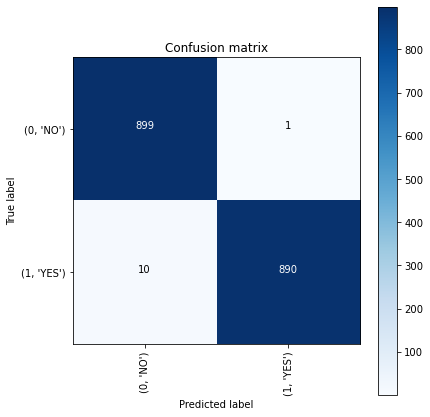

------------------------ Validation Set Metrics------------------------

Accuracy score : 81.67%


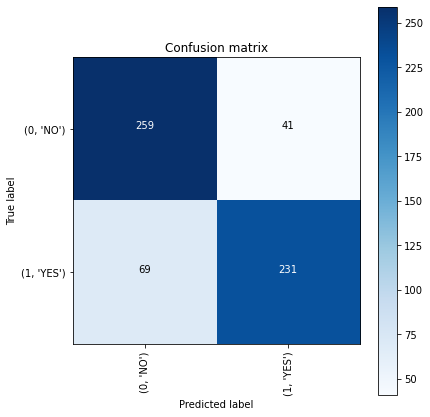

------------------------ Test Set Metrics------------------------

Accuracy score : 81.17%
F1_score : 0.81
Kappa Score : 0.62 
Recall score: 0.81
Precision score : 0.82
ROC AUC score : 0.8116666666666668


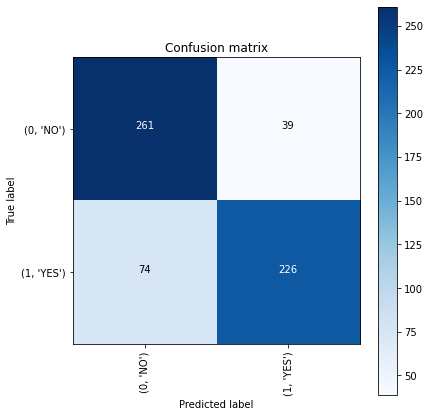

		Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.87      0.82       300
           1       0.85      0.75      0.80       300

    accuracy                           0.81       600
   macro avg       0.82      0.81      0.81       600
weighted avg       0.82      0.81      0.81       600

--------------------------------------------------------------------------------



In [91]:
classifier_comparator(train_features,y_train,val_features,y_val,test_features,y_test,classifier=zipped_clf)

# DenseNet-121

In [94]:
base_model= DenseNet121(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
predictions = Activation('relu')(x)
#x = Dropout(0.5)(x)
#predictions = Dense(3, activation='softmax')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(X_train_prep)
val_features=model_feat.predict(X_val_prep)
test_features=model_feat.predict(X_test_prep)

29089792/29084464 [==============================] - 0s 0us/step


------------------------------Fitting K Nearest Neighbour Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 87.5%


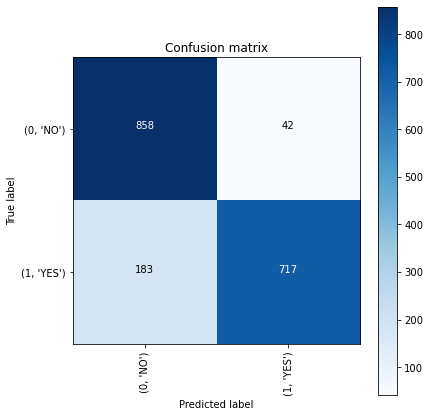

------------------------ Validation Set Metrics------------------------

Accuracy score : 81.5%


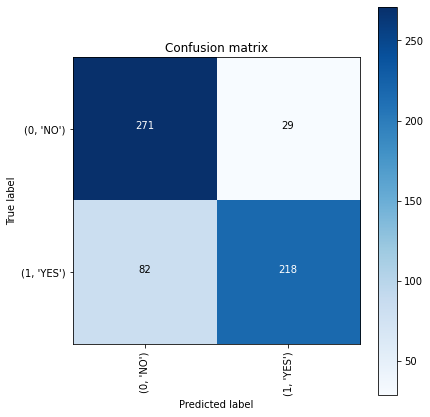

------------------------ Test Set Metrics------------------------

Accuracy score : 81.17%
F1_score : 0.81
Kappa Score : 0.62 
Recall score: 0.81
Precision score : 0.82
ROC AUC score : 0.8116666666666665


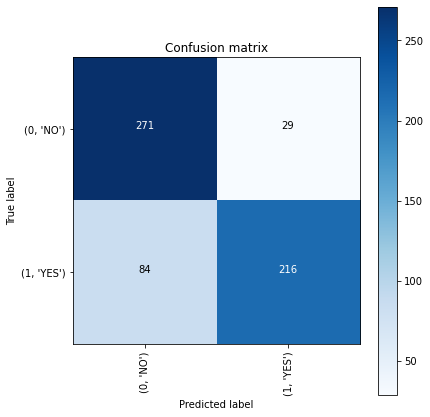

		Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.90      0.83       300
           1       0.88      0.72      0.79       300

    accuracy                           0.81       600
   macro avg       0.82      0.81      0.81       600
weighted avg       0.82      0.81      0.81       600

--------------------------------------------------------------------------------

------------------------------Fitting SVM on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 79.83%


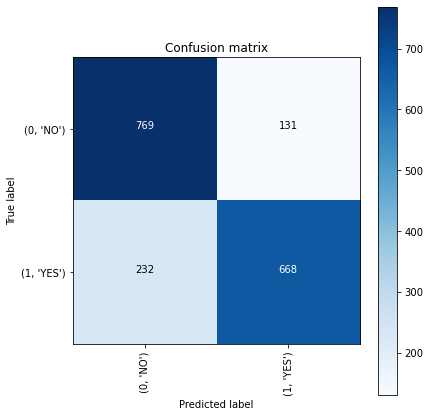

------------------------ Validation Set Metrics------------------------

Accuracy score : 74.83%


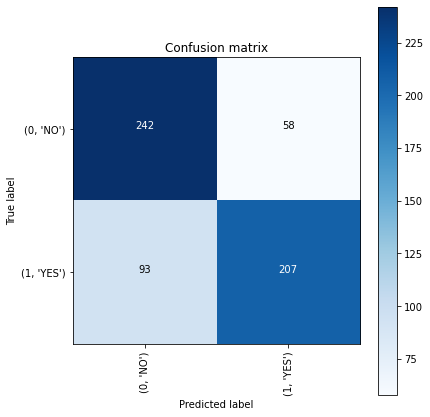

------------------------ Test Set Metrics------------------------

Accuracy score : 74.17%
F1_score : 0.74
Kappa Score : 0.48 
Recall score: 0.74
Precision score : 0.75
ROC AUC score : 0.7416666666666667


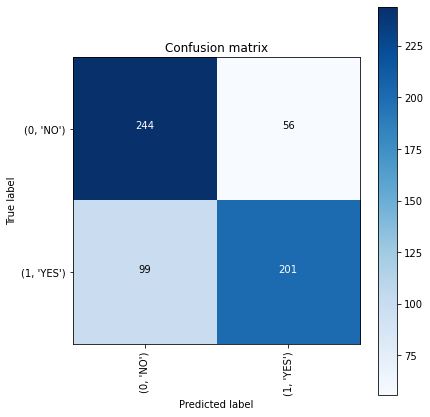

		Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.81      0.76       300
           1       0.78      0.67      0.72       300

    accuracy                           0.74       600
   macro avg       0.75      0.74      0.74       600
weighted avg       0.75      0.74      0.74       600

--------------------------------------------------------------------------------

------------------------------Fitting Random Forest Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


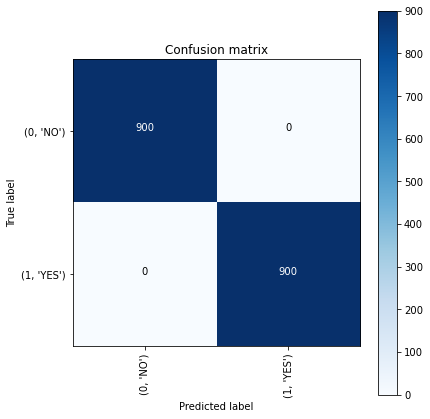

------------------------ Validation Set Metrics------------------------

Accuracy score : 81.33%


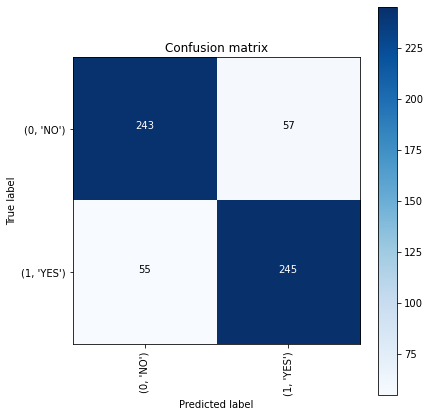

------------------------ Test Set Metrics------------------------

Accuracy score : 81.5%
F1_score : 0.81
Kappa Score : 0.63 
Recall score: 0.82
Precision score : 0.82
ROC AUC score : 0.8150000000000001


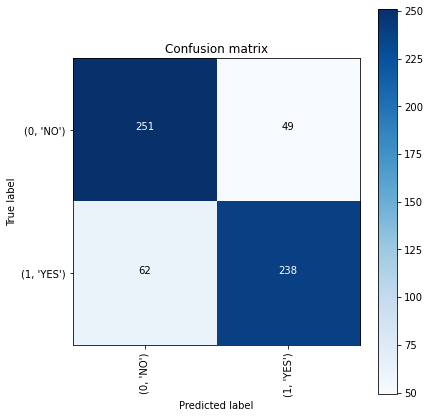

		Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82       300
           1       0.83      0.79      0.81       300

    accuracy                           0.81       600
   macro avg       0.82      0.81      0.81       600
weighted avg       0.82      0.81      0.81       600

--------------------------------------------------------------------------------

------------------------------Fitting AdaBoost Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 78.06%


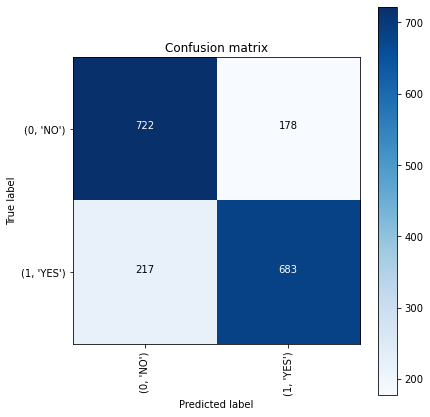

------------------------ Validation Set Metrics------------------------

Accuracy score : 67.67%


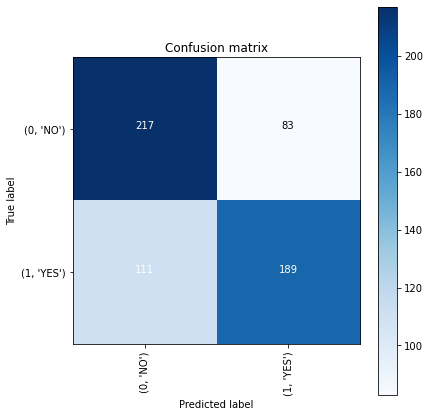

------------------------ Test Set Metrics------------------------

Accuracy score : 69.5%
F1_score : 0.69
Kappa Score : 0.39 
Recall score: 0.7
Precision score : 0.7
ROC AUC score : 0.6950000000000001


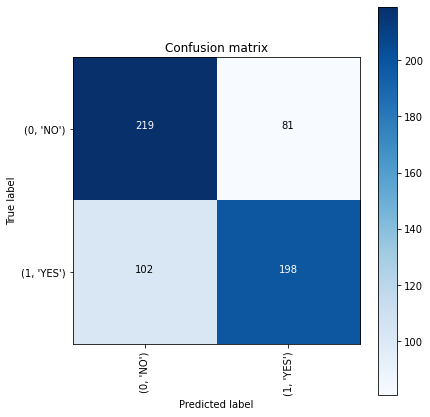

		Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.73      0.71       300
           1       0.71      0.66      0.68       300

    accuracy                           0.69       600
   macro avg       0.70      0.70      0.69       600
weighted avg       0.70      0.69      0.69       600

--------------------------------------------------------------------------------

------------------------------Fitting XGB Classifier on input_data-------------------------------- 
[17:00:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].




------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


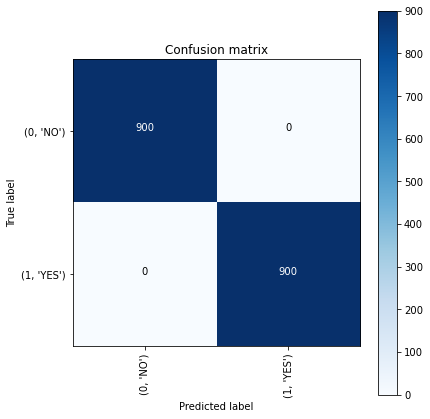

------------------------ Validation Set Metrics------------------------

Accuracy score : 81.5%


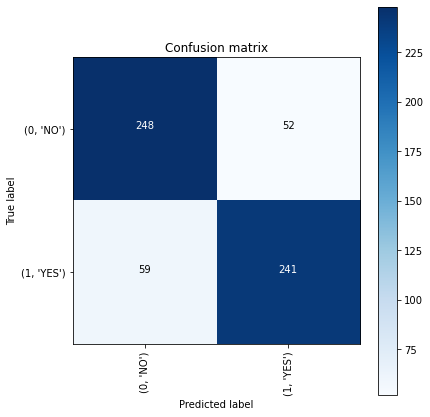

------------------------ Test Set Metrics------------------------

Accuracy score : 82.17%
F1_score : 0.82
Kappa Score : 0.64 
Recall score: 0.82
Precision score : 0.82
ROC AUC score : 0.8216666666666667


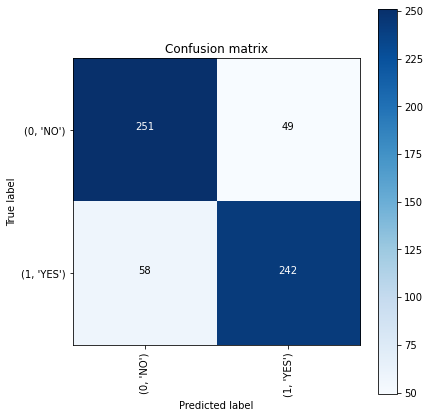

		Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.84      0.82       300
           1       0.83      0.81      0.82       300

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600

--------------------------------------------------------------------------------

------------------------------Fitting ANN Classifier on input_data-------------------------------- 


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.




------------------------ Train Set Metrics------------------------

Accuracy core : 99.94%


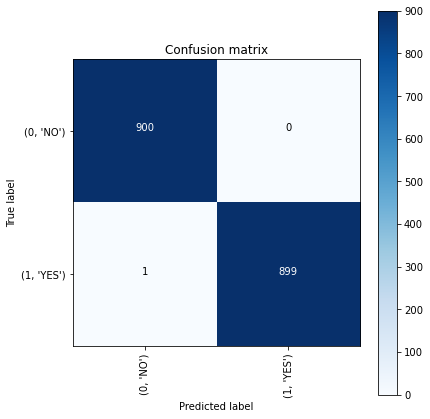

------------------------ Validation Set Metrics------------------------

Accuracy score : 83.0%


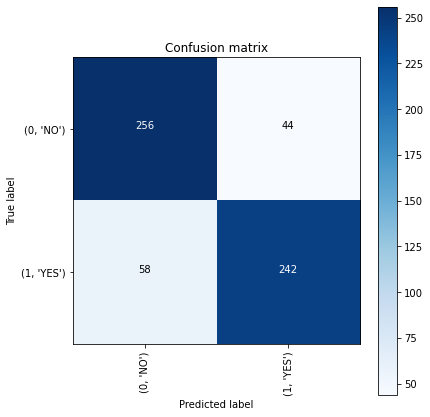

------------------------ Test Set Metrics------------------------

Accuracy score : 81.17%
F1_score : 0.81
Kappa Score : 0.62 
Recall score: 0.81
Precision score : 0.82
ROC AUC score : 0.8116666666666665


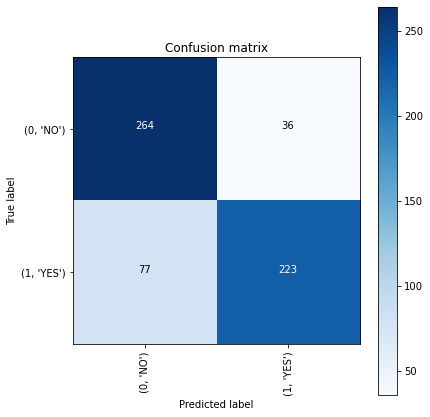

		Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82       300
           1       0.86      0.74      0.80       300

    accuracy                           0.81       600
   macro avg       0.82      0.81      0.81       600
weighted avg       0.82      0.81      0.81       600

--------------------------------------------------------------------------------



In [95]:
classifier_comparator(train_features,y_train,val_features,y_val,test_features,y_test,classifier=zipped_clf)

# XceptionNet

In [98]:
base_model= Xception(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
predictions = Activation('relu')(x)
#x = Dropout(0.5)(x)
#predictions = Dense(3, activation='softmax')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(X_train_prep)
val_features=model_feat.predict(X_val_prep)
test_features=model_feat.predict(X_test_prep)

83689472/83683744 [==============================] - 1s 0us/step


------------------------------Fitting K Nearest Neighbour Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 86.39%


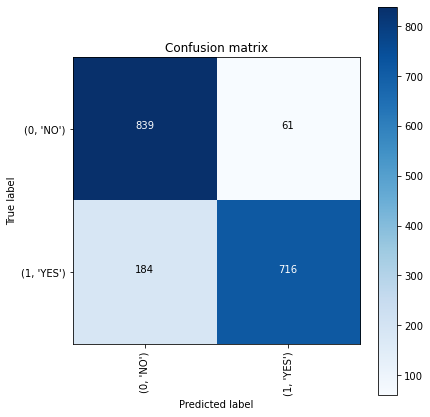

------------------------ Validation Set Metrics------------------------

Accuracy score : 76.17%


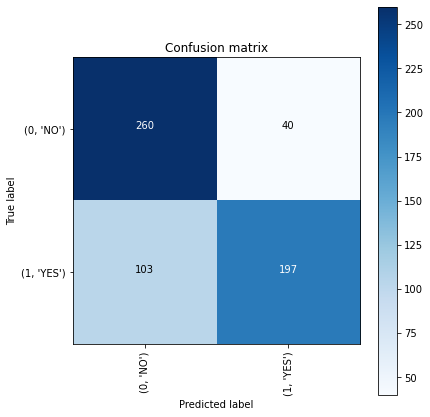

------------------------ Test Set Metrics------------------------

Accuracy score : 75.5%
F1_score : 0.75
Kappa Score : 0.51 
Recall score: 0.76
Precision score : 0.77
ROC AUC score : 0.7549999999999999


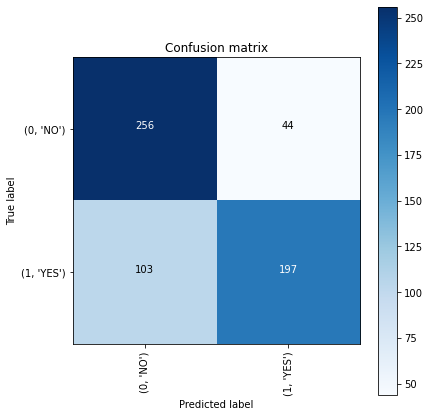

		Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.85      0.78       300
           1       0.82      0.66      0.73       300

    accuracy                           0.76       600
   macro avg       0.77      0.76      0.75       600
weighted avg       0.77      0.76      0.75       600

--------------------------------------------------------------------------------

------------------------------Fitting SVM on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 86.11%


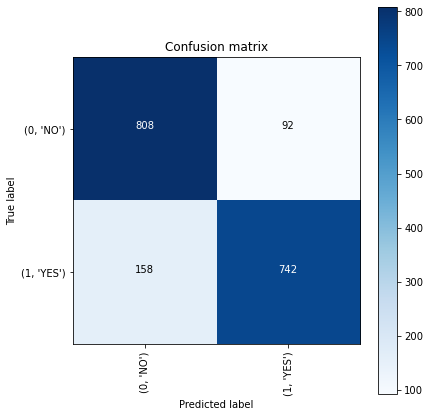

------------------------ Validation Set Metrics------------------------

Accuracy score : 79.0%


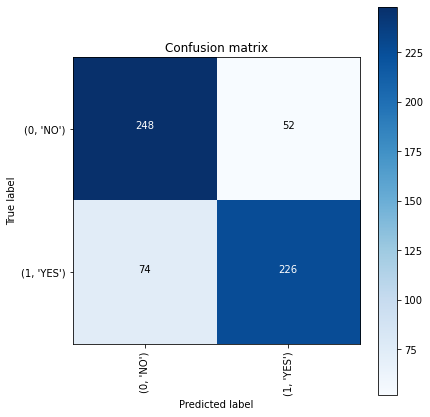

------------------------ Test Set Metrics------------------------

Accuracy score : 76.5%
F1_score : 0.76
Kappa Score : 0.53 
Recall score: 0.76
Precision score : 0.77
ROC AUC score : 0.765


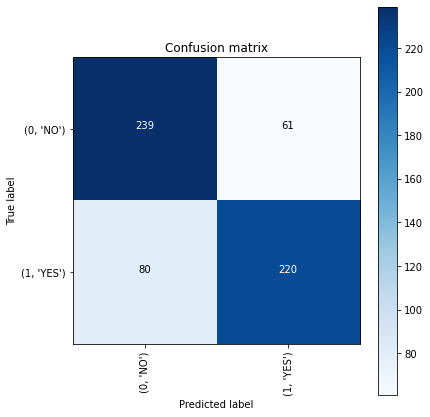

		Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.80      0.77       300
           1       0.78      0.73      0.76       300

    accuracy                           0.77       600
   macro avg       0.77      0.76      0.76       600
weighted avg       0.77      0.77      0.76       600

--------------------------------------------------------------------------------

------------------------------Fitting Random Forest Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


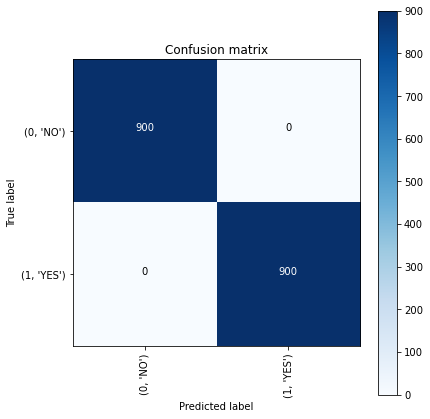

------------------------ Validation Set Metrics------------------------

Accuracy score : 79.5%


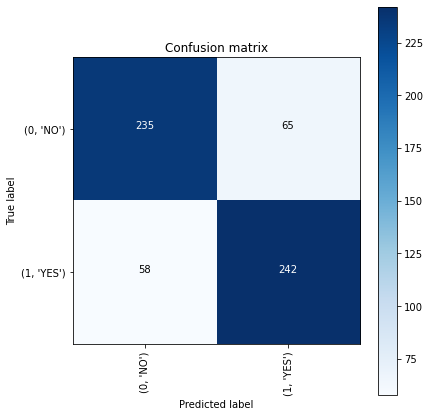

------------------------ Test Set Metrics------------------------

Accuracy score : 77.5%
F1_score : 0.77
Kappa Score : 0.55 
Recall score: 0.78
Precision score : 0.78
ROC AUC score : 0.7749999999999999


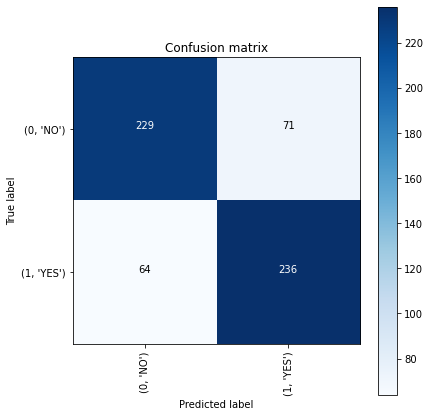

		Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.76      0.77       300
           1       0.77      0.79      0.78       300

    accuracy                           0.78       600
   macro avg       0.78      0.77      0.77       600
weighted avg       0.78      0.78      0.77       600

--------------------------------------------------------------------------------

------------------------------Fitting AdaBoost Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 80.56%


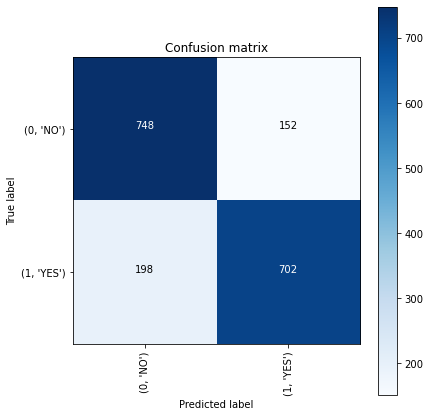

------------------------ Validation Set Metrics------------------------

Accuracy score : 73.5%


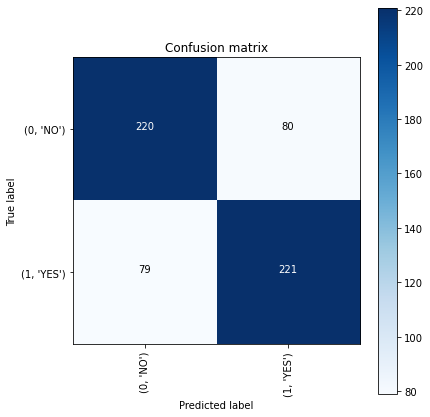

------------------------ Test Set Metrics------------------------

Accuracy score : 71.0%
F1_score : 0.71
Kappa Score : 0.42 
Recall score: 0.71
Precision score : 0.71
ROC AUC score : 0.71


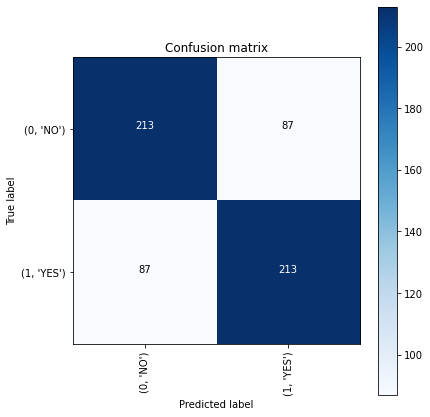

		Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71       300
           1       0.71      0.71      0.71       300

    accuracy                           0.71       600
   macro avg       0.71      0.71      0.71       600
weighted avg       0.71      0.71      0.71       600

--------------------------------------------------------------------------------

------------------------------Fitting XGB Classifier on input_data-------------------------------- 


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[17:01:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


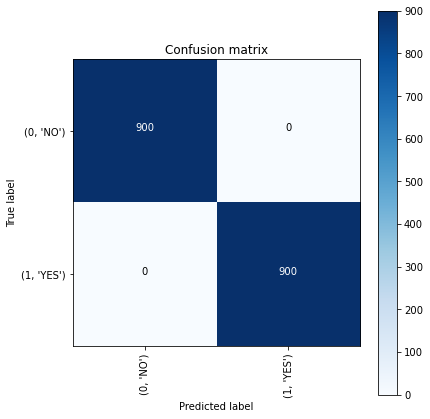

------------------------ Validation Set Metrics------------------------

Accuracy score : 80.83%


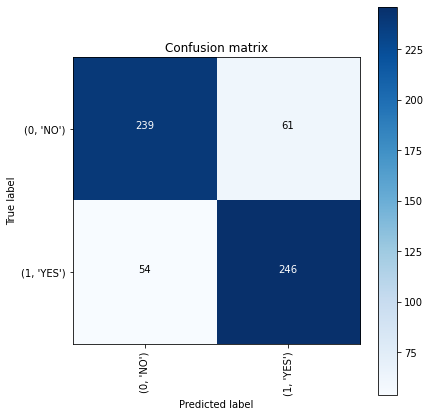

------------------------ Test Set Metrics------------------------

Accuracy score : 81.0%
F1_score : 0.81
Kappa Score : 0.62 
Recall score: 0.81
Precision score : 0.81
ROC AUC score : 0.8099999999999999


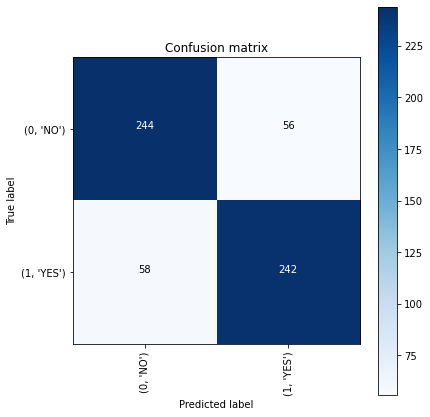

		Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81       300
           1       0.81      0.81      0.81       300

    accuracy                           0.81       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.81      0.81      0.81       600

--------------------------------------------------------------------------------

------------------------------Fitting ANN Classifier on input_data-------------------------------- 


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.




------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%


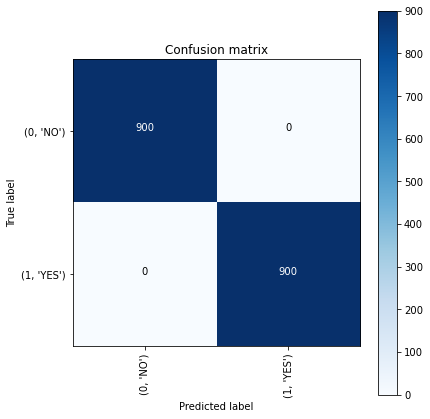

------------------------ Validation Set Metrics------------------------

Accuracy score : 81.33%


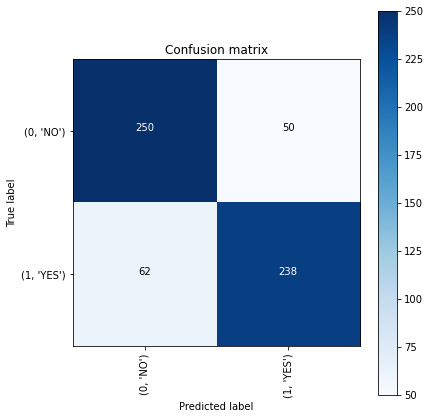

------------------------ Test Set Metrics------------------------

Accuracy score : 81.33%
F1_score : 0.81
Kappa Score : 0.63 
Recall score: 0.81
Precision score : 0.81
ROC AUC score : 0.8133333333333335


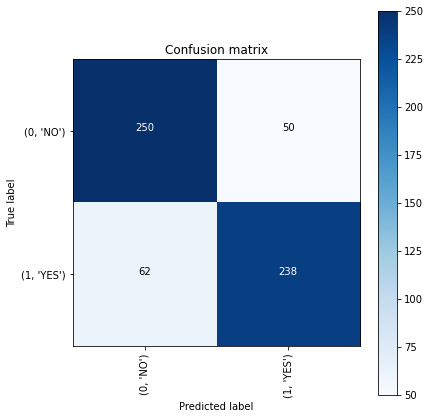

		Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.82       300
           1       0.83      0.79      0.81       300

    accuracy                           0.81       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.81      0.81      0.81       600

--------------------------------------------------------------------------------



In [99]:
classifier_comparator(train_features,y_train,val_features,y_val,test_features,y_test,classifier=zipped_clf)

In [100]:
# clean up the space
!rm -rf TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP